# Vehicle Detection and Tracking

The goal is to write a software pipeline to detect vehicles in a video

steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
import csv
import cv2
import json
import numpy as np
import math
import pickle
import os
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
from sklearn.svm import LinearSVC
from skimage.feature import hog
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
#import vd_common
from vd_common import configure
from vd_common import color_hist
from vd_common import prepareDataFromCSV
from vd_common import extract_features
from vd_common import extract_features_for_type
from vd_common import extract_features_for_type
from vd_common import normalize_and_split
from vd_common import normalization
from vd_common import get_orient
from vd_common import get_pix_per_cell
from vd_common import get_cell_per_block
from vd_common import get_hog_channel
from vd_common import get_spatial_size
from vd_common import get_hist_bins
from vd_common import get_hist_range
from vd_common import get_spatial_feat
from vd_common import get_hist_feat
from vd_common import get_hog_feat
from vd_common import get_color_space
from vd_common import convert_color
from vd_common import color_hist
from vd_common import bin_spatial
from vd_common import data_look
from vd_common import get_hog_features
from vd_common import train_classifier
from vd_common import find_cars
from vd_common import add_heat
from vd_common import apply_threshold
from vd_common import draw_labeled_bboxes
from vd_common import pipeline

some configuration functions which are used in the pipeline

In [326]:
def get_spatial_size():
    return (32, 32)

def get_hist_bins():
    return 32

def get_orient():
    return 9

def get_pix_per_cell():
    return 8

def get_cell_per_block():
    return 2

def get_hog_channel():
    return "ALL"

def get_spatial_feat():
    return True

def get_hist_feat():
    return True

def get_color_space():
    return  "YCrCb"

def get_hist_range():
    return (0, 256)

def get_hog_feat():
    return True


# Example of data set

The simple data set is used for this project. It consists of two folders: cars and non cars. We read these folders using glob function. As the result we have two lists with filenames to be used later.

In [5]:

cars = glob.glob('vehicles/vehicles/*/*.png')
not_cars = glob.glob('non-vehicles/non-vehicles/*/*.png')
example_car = mpimg.imread(cars[80])
example_notcar = mpimg.imread(not_cars[0])

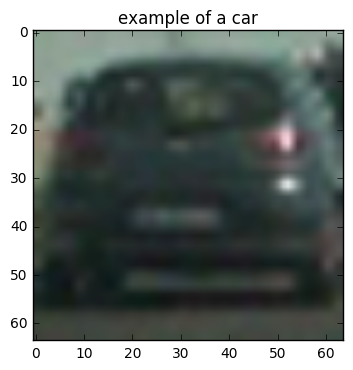

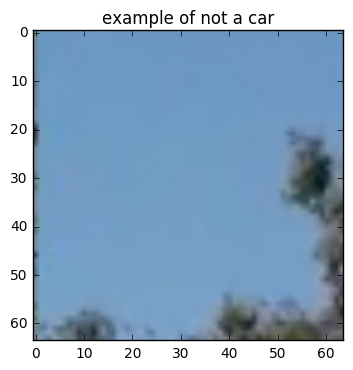

In [467]:
plt.imshow(example_car)
#plt.savefig("test_images/car_example.jpg")
plt.title('example of a car')
plt.show()

plt.imshow(example_notcar)
plt.title('example of not a car')
#plt.savefig(\"color_warp\" + str(rand_int) +\".jpg\")\n",
plt.show()

A helper function to perform color space convertion. It has two input parameters: the source image and the second is string which defines what convertion to perform. The method returns a converted image

In [338]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)   
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)     

## Colors histogram

For car detection we can't use template mathcing approach directly, unfortunately because in this case we woudln't be able to have all templates for any case might ever happen. But we can use some image characteristics, pixel intensity for example. For this purpose we can use histograms. in the method below we are constructing a histogram for R, G and B channels for RGB-image. 

In [8]:
def color_hist(img, nbins=32, bins_range=(0.0, 256.0)):
    # Compute the histogram of the RGB channels separately
    #print ("bins_range", bins_range)
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

Here is the an example of using the "color_hist" method for the car image (the same as above). You can see that image has significant values, which can be easily determined and considered for further usage, for each channel.

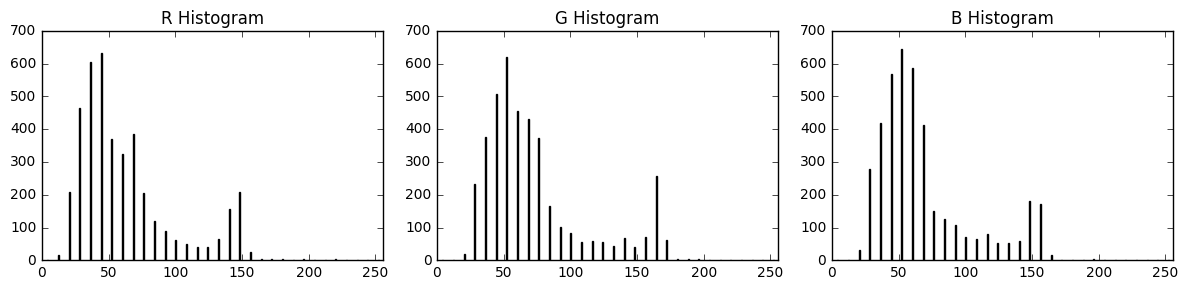

In [9]:
test_image = cv2.imread(cars[80])
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

rhist, ghist, bhist, bin_centers, hist_features = color_hist(test_image, nbins=32, bins_range=(0.0, 256.0))

if rhist is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bin_centers, rhist[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bin_centers, ghist[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bin_centers, bhist[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
    plt.show()

Example of usage the same method for non a car image (e.g sky or road). As you can see the intensity of values for each channel is much less than for a car image. This feature we will use in our pipeline.

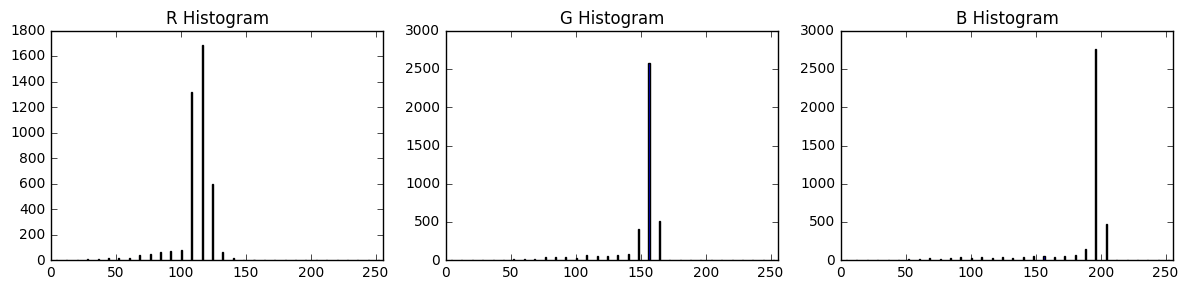

In [10]:
test_image = cv2.imread(not_cars[0])
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

rhist, ghist, bhist, bin_centers, hist_features = color_hist(test_image, nbins=32, bins_range=(0.0, 256.0))

if rhist is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bin_centers, rhist[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bin_centers, ghist[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bin_centers, bhist[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
    plt.show()

This is the helper function to draw blue boxes around detected cars

In [11]:
# Helper function to draw bounding boxes
def draw_boxes(img,boxes,color=(0,0,255),thick=6):
    draw_img=np.copy(img)
    for bbox in boxes:
        cv2.rectangle(draw_img,bbox[0],bbox[1],color,thick)
    return draw_img

## Creating feature vector from image

As it could be noticed earlier the car and not car images are not in high resolution, even we can say - in very small. But car still can be determined normally by eye. So it means that the small image still have enough features to distinguish cars and not cars. The method below does resizing down the input image (e.g. to resize it to 32x32 pixels) and converts it to the one dimensional vector which is convenient to use in our classificator. 

In [12]:
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    # Use cv2.resize().ravel() to create the feature vector
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)       
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

An example of usage the method described above for different colorspaces. As we can see for car image the colorspace YCrCb gives us the well defined border. This feature is very usefull to detec the necessary pixes of a car image.

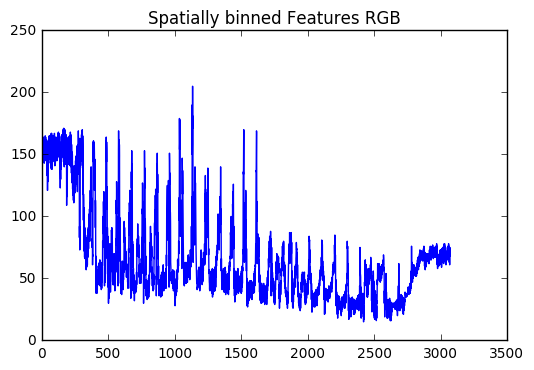

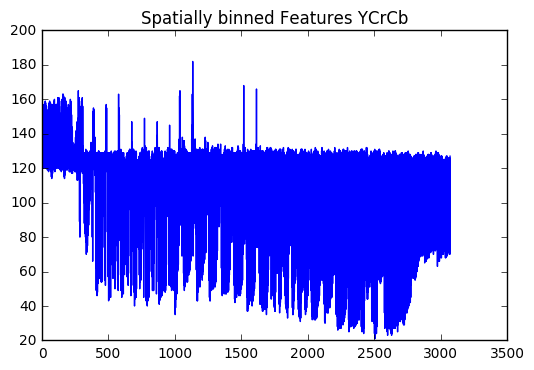

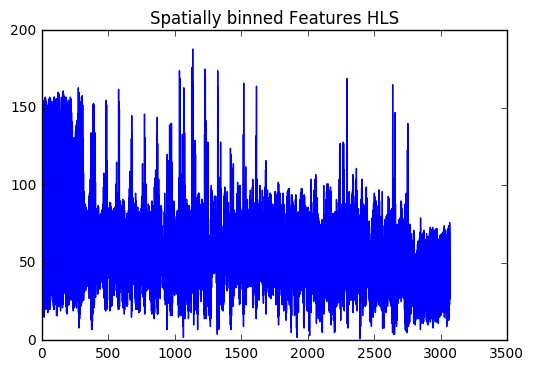

In [469]:
test_image = cv2.imread(cars[80])
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
features_RGB = bin_spatial(test_image)
features_HSV = bin_spatial(test_image, color_space='YCrCb')
features_HLS = bin_spatial(test_image, color_space='HLS')

plt.plot(features_RGB)
plt.title('Spatially binned Features RGB')
plt.show()

plt.plot(features_HSV)
plt.title('Spatially binned Features YCrCb')
plt.show()

plt.plot(features_HLS)
plt.title('Spatially binned Features HLS')
plt.show()

# Hog Features extraction

HOG - Histogram of Oriented Gradient features
The main purpose of this is to use object features, a car in our case, such as corners, edges and etc. Definitely a car image has them. A good explanation can be found here: http://www.learnopencv.com/histogram-of-oriented-gradients/. Below you can see 2 images of HOG results representation: for car image and for not a car image. This representation shows the dominant gradient direction within each cell with brightness corresponding to the strength of gradients in that cell. The hog function parameters description can be found here: http://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=feature%20hog#skimage.feature.hog

In [14]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

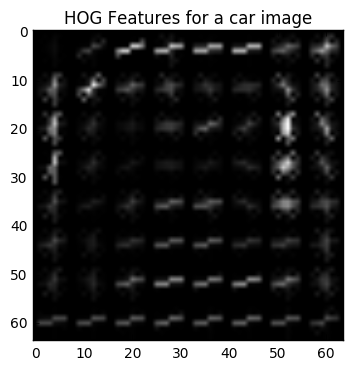

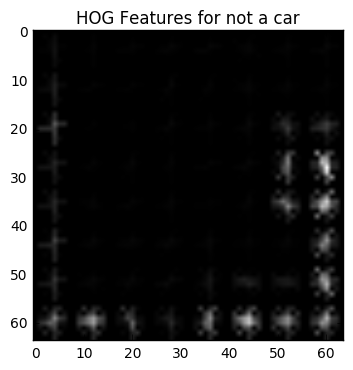

In [493]:
test_image = cv2.imread(cars[80])
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
orient = get_orient()
pix_per_cell = get_pix_per_cell()
cell_per_block = get_cell_per_block()

features, hog_image = get_hog_features(test_image, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

plt.imshow(hog_image, cmap='gray')
plt.title('HOG Features for a car image')
plt.show()

test_image = cv2.imread(not_cars[0])
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
features, hog_image = get_hog_features(test_image, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

plt.imshow(hog_image, cmap='gray')
plt.title('HOG Features for not a car')
plt.show()

# Features extration

The method below does feature extraction from the particular image. It combines all the techniks we used previously - color, spatial histograms, HOG. It recieves a list of images to extract features from and returns a list features.

In [16]:
def extract_features(img_list, spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0.0, 256.0),
                        orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img in img_list:
        combined_features = []
        image = mpimg.imread(img, format='PNG')
        #image = image.astype(np.float32)/255
        # apply color conversion if other than 'RGB'
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)     
        
        
        if spatial_feat:
            # Apply bin_spatial() to get spatial color features
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            combined_features.append(spatial_features)
        if hist_feat:
            # Apply color_hist() also with a color space option now
            rhist, ghist, bhist, bin_centers, hist_features = color_hist(feature_image, hist_bins, hist_range)
            combined_features.append(hist_features)
        if hog_feat:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel],
                                                orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            combined_features.append(hog_features)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate(combined_features))
    # Return list of feature vectors
    return features


It is the wrapper for the feature extration method. It incapsulates some configuration stuff and the method below has only 1 input parameter - list of images 

In [17]:
def extract_features_for_type(img_list):

    spatial_size = get_spatial_size() 
    hist_bins = get_hist_bins()  
    orient = get_orient()  
    pix_per_cell = get_pix_per_cell() 
    cell_per_block = get_cell_per_block() 
    hog_channel = get_hog_channel() 
    spatial_feat =  get_spatial_feat() 
    hist_feat = get_hist_feat()  
    color_space = get_color_space() 
    hist_range = get_hist_range()
    hog_feat = get_hog_feat()
    
    features = extract_features(img_list, spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=hist_range,
                        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    return features

This is example of usage of "extract_features_for_type".

In [19]:
cars_features = extract_features_for_type(cars)
notcars_features = extract_features_for_type(not_cars)

# Normalize and split data

When features from images (both cars and not cars) are extracted the next step is to normalize the input data. In our case the input data will be extracted features. For normalization standart scikit function StandardScaler is used. After when data is normalized it is mixed up and splited.

In [20]:
X = np.vstack((cars_features, notcars_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X) #normalization(cars_features, notcars_features)

y = np.hstack((np.ones(len(cars_features)), np.zeros(len(notcars_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

# Train the model

For classification job the LinearSVC() = Linear Support Vector Classificatio has been chosen. It has flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples - exactly our case! I use it with default configuration.

In [21]:
svc = LinearSVC()
svc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

# Find a car

Here I use sliding windows approach which has fixed small size and this window goes through the original image - hog sub-sampling window search. The method below is able to both extract features and make predictions. The find_cars only has to extract hog features once and then can be sub-sampled to get all of its overlaying windows. Each window is defined by a scaling factor - scale. In the final pipeline we will run this function multiple times for different scale values to generate multiple-scaled search windows.

In [554]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins, hist_range):
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv="RGB2YCrCb")
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    nxblocks = (ctrans_tosearch.shape[1] // pix_per_cell)-1
    nyblocks = (ctrans_tosearch.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    if hog_channel == 'ALL':
        hog = []
        for channel in range(ctrans_tosearch.shape[2]):
            hog.append(get_hog_features(ctrans_tosearch[:,:,channel], orient, pix_per_cell, cell_per_block, feature_vec=False))
    else:
        hog = get_hog_features(ctrans_tosearch[:,:,hog_channel], orient, pix_per_cell, cell_per_block, feature_vec=False)

    img_boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(ctrans_tosearch.shape[2]):
                    hog_features.append(hog[channel][ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel())
                hog_features = np.hstack(hog_features)
            else:
                hog_features = hog[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            rhist, ghist, bhist, bin_centers, hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                img_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))                
                
    return img_boxes

# Find cars

The code below demostrates the usage example of the find_car method

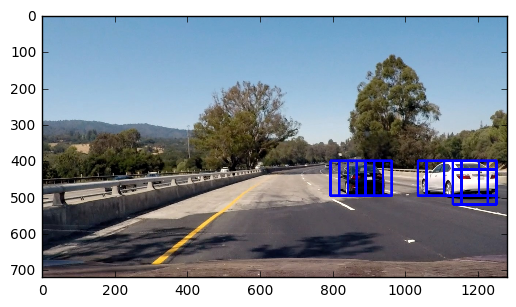

In [555]:
spatial_size = get_spatial_size() 
hist_bins = get_hist_bins()  
orient = get_orient()  
pix_per_cell = get_pix_per_cell() 
cell_per_block = get_cell_per_block() 
hog_channel = get_hog_channel() 
spatial_feat =  get_spatial_feat() 
hist_feat = get_hist_feat()  
color_space = get_color_space() 
hist_range = get_hist_range()
hog_feat = get_hog_feat()
ystart = 400
ystop = 700
scale = 1.5
img = mpimg.imread('test_images/test4.jpg')
boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins, hist_range)
find_image = draw_boxes(img, boxes)
plt.imshow(find_image)
plt.show()

# Heat map to avoid false positives

To remove false positive detections we build a heat-map from these detections in order to combine overlapping detections. To make a heat-map, we simply going to add "heat" (+=1) for all pixels within windows where a positive detection is reported by the classifier. By imposing a threshold, we can reject areas affected by false positives. To figure out how many cars we have in each frame and which pixels belong to which cars, we use the label() function from scipy.ndimage.measurements; labels is a 2-tuple, where the first item is an array the size of the heatmap input image and the second element is the number of labels (cars) found.

In [556]:
def add_heat(image, bbox_list):
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    #return heatmap# Iterate through list of bboxes
    return np.clip(heatmap, 0, 255)
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

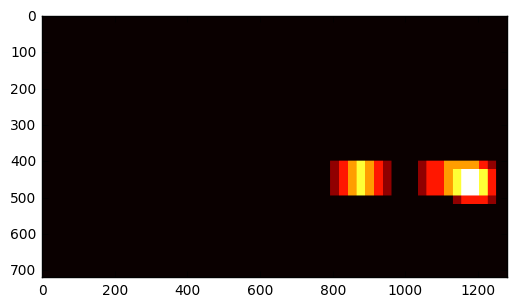

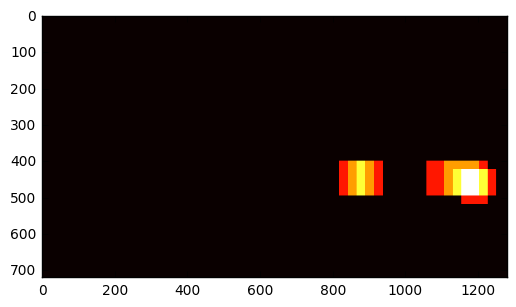

found cars 2


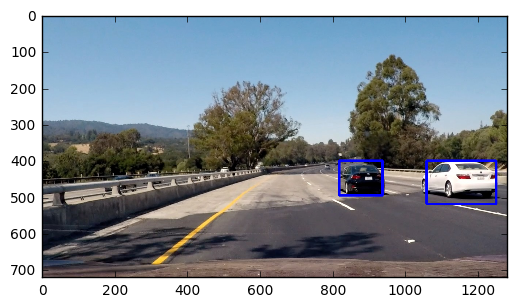

In [557]:
heat = add_heat(find_image, boxes)
plt.imshow(heat, cmap="hot")
plt.show()
heat_w_tresh = apply_threshold(heat, 1)
plt.imshow(heat_w_tresh, cmap="hot")
plt.show()

car_labels = label(heat_w_tresh)
print("found cars", car_labels[1])

result = draw_labeled_bboxes(np.copy(img), car_labels)
plt.imshow(result)
plt.show()

# Pipeline

This is the built pipeline for car detection

In [591]:
def pipeline(img):
    spatial_size = get_spatial_size() 
    hist_bins = get_hist_bins()  
    orient = get_orient()  
    pix_per_cell = get_pix_per_cell() 
    cell_per_block = get_cell_per_block() 
    hog_channel = get_hog_channel() 
    spatial_feat =  get_spatial_feat() 
    hist_feat = get_hist_feat()  
    color_space = get_color_space() 
    hist_range = get_hist_range()
    hog_feat = get_hog_feat()
    from random import randrange
    rand_int = randrange(1700000)
    #cv2.imwrite("temp/origin" + str(rand_int) +".jpg", cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    boxes = []
    for (ystart, ystop, scale, factor) in [(380, 580, 1, 5), (380, 500, 1.25, 5) , (380, 600, 1.5, 5), (380, 650, 1.75, 7), (450, 680, 2, 7), (450, 680, 5, 2)]:
        boxes += find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins, hist_range)
        heat = add_heat(img, boxes)
        #plt.imshow(heat, cmap="hot")
        #plt.show()
        heat_w_tresh = apply_threshold(heat, factor)
        #plt.imshow(heat_w_tresh, cmap="hot")
        #plt.show()
        car_labels = label(heat_w_tresh)
        #print("found cars", car_labels[1])
        result = draw_labeled_bboxes(np.copy(img), car_labels)
        #plt.imshow(result)
        #plt.show()
        
    #cv2.imwrite("temp/result" + str(rand_int) +".jpg", cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    return result

# Test pipeline on image

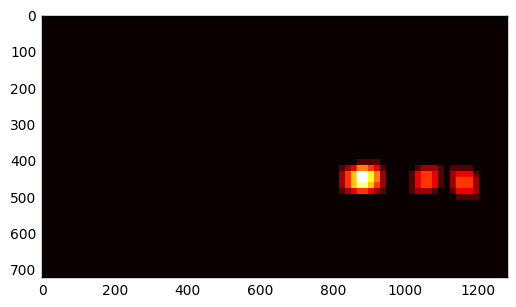

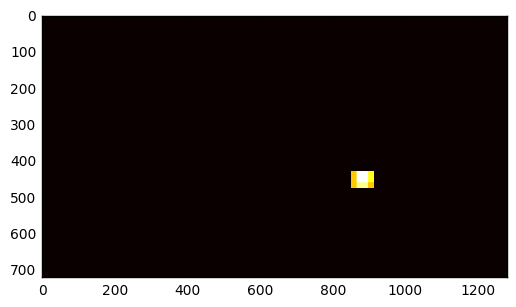

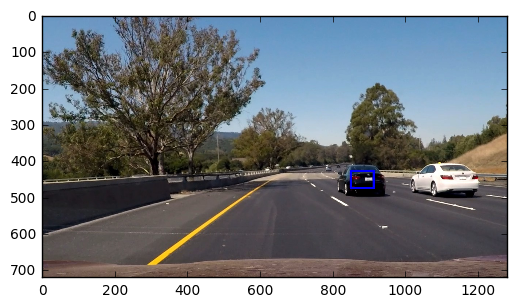

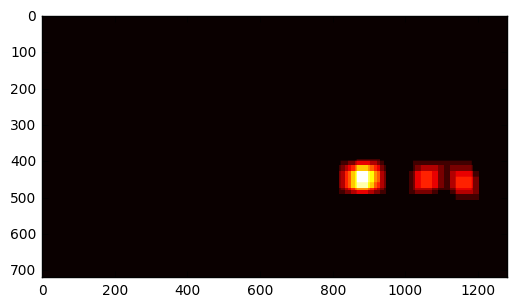

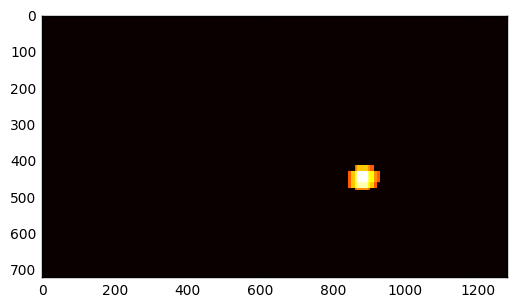

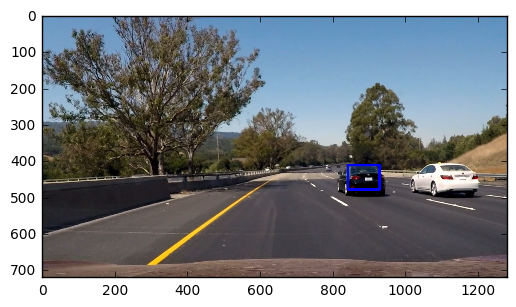

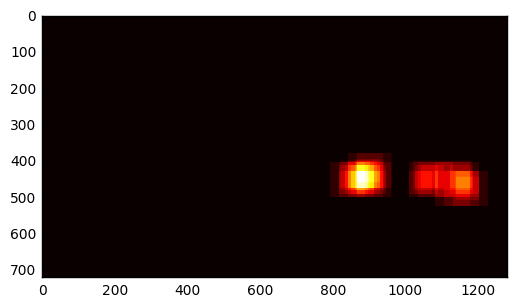

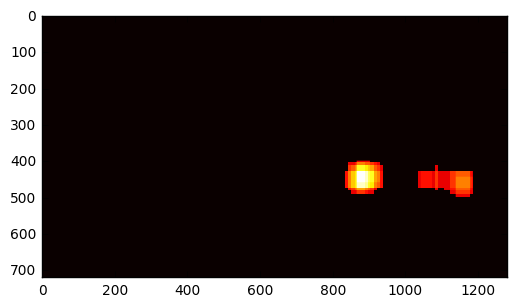

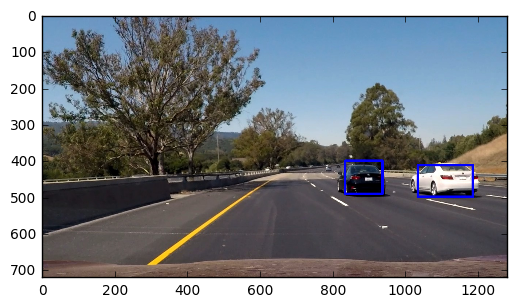

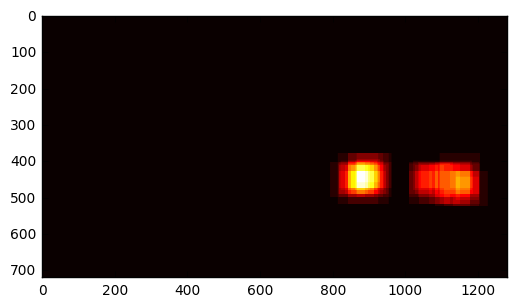

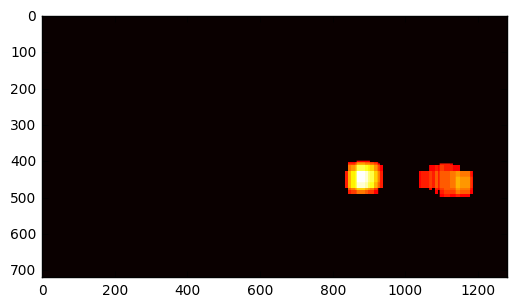

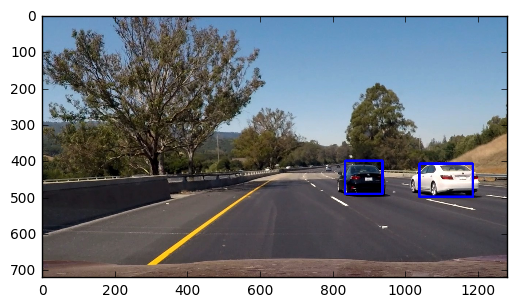

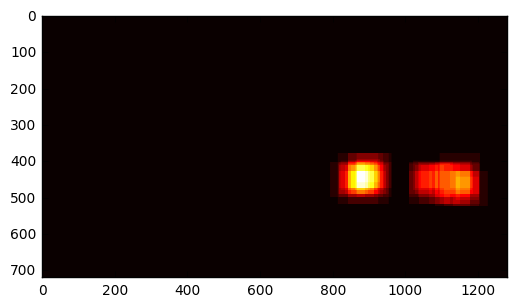

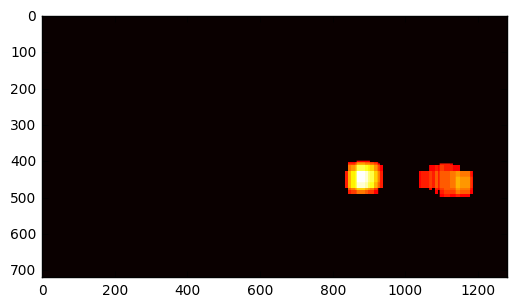

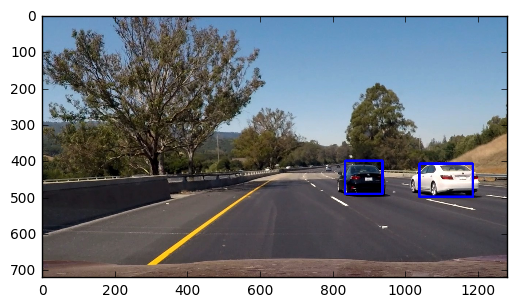

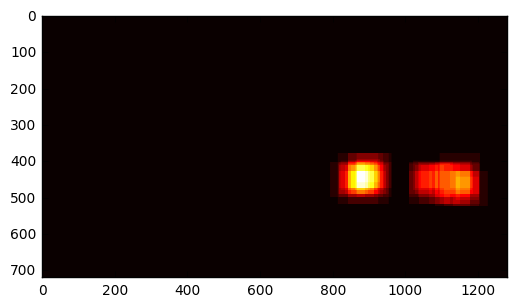

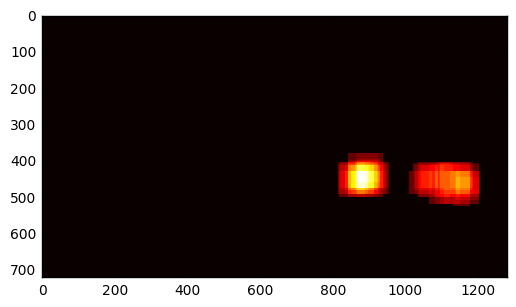

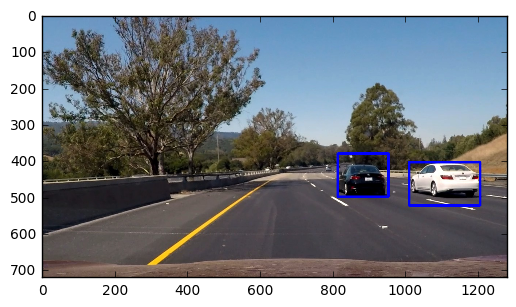

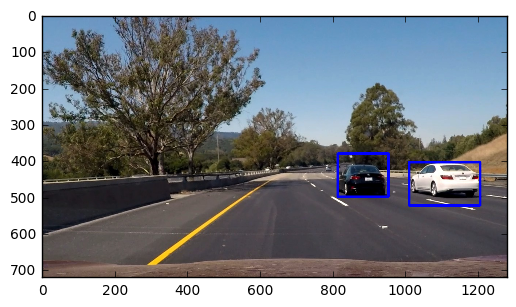

In [603]:
file = "test6.jpg"
img = mpimg.imread("test_images/" + file)
#img = mpimg.imread('temp/origin812107.jpg') #1369010.jpg')
result = pipeline(img)
#cv2.imwrite("output_images/" + file, cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.imshow(result)
plt.show()

# Test pipeline on video

In [196]:
output_file = "project5_video.mp4"
clip = VideoFileClip("project_video.mp4") #input test video file

# fl_image: Modifies the images of a clip by replacing the frame by another frame
output = clip.fl_image(pipeline) #call the pipeline 

%time output.write_videofile(output_file, audio=False) # save the video

found cars 0
[MoviePy] >>>> Building video project5_video.mp4
[MoviePy] Writing video project5_video.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:01<38:26,  1.83s/it]

found cars 0




  0%|          | 2/1261 [00:03<38:57,  1.86s/it]

found cars 0




  0%|          | 3/1261 [00:05<37:40,  1.80s/it]

found cars 0




  0%|          | 4/1261 [00:07<37:25,  1.79s/it]

found cars 0




  0%|          | 5/1261 [00:09<38:15,  1.83s/it]

found cars 0




  0%|          | 6/1261 [00:11<39:48,  1.90s/it]

found cars 0




  1%|          | 7/1261 [00:12<39:08,  1.87s/it]

found cars 0




  1%|          | 8/1261 [00:14<39:14,  1.88s/it]

found cars 1




  1%|          | 9/1261 [00:16<39:46,  1.91s/it]

found cars 0




  1%|          | 10/1261 [00:18<40:39,  1.95s/it]

found cars 0




  1%|          | 11/1261 [00:20<39:17,  1.89s/it]

found cars 0




  1%|          | 12/1261 [00:22<39:03,  1.88s/it]

found cars 0




  1%|          | 13/1261 [00:24<39:57,  1.92s/it]

found cars 0




  1%|          | 14/1261 [00:26<42:45,  2.06s/it]

found cars 0




  1%|          | 15/1261 [00:29<45:32,  2.19s/it]

found cars 0




  1%|▏         | 16/1261 [00:31<44:40,  2.15s/it]

found cars 0




  1%|▏         | 17/1261 [00:33<42:49,  2.07s/it]

found cars 0




  1%|▏         | 18/1261 [00:35<43:44,  2.11s/it]

found cars 0




  2%|▏         | 19/1261 [00:37<44:29,  2.15s/it]

found cars 0




  2%|▏         | 20/1261 [00:39<44:54,  2.17s/it]

found cars 0




  2%|▏         | 21/1261 [00:42<46:24,  2.25s/it]

found cars 0




  2%|▏         | 22/1261 [00:44<47:01,  2.28s/it]

found cars 0




  2%|▏         | 23/1261 [00:47<48:36,  2.36s/it]

found cars 0




  2%|▏         | 24/1261 [00:49<47:59,  2.33s/it]

found cars 0




  2%|▏         | 25/1261 [00:51<48:30,  2.36s/it]

found cars 0




  2%|▏         | 26/1261 [00:54<47:39,  2.32s/it]

found cars 0




  2%|▏         | 27/1261 [00:56<46:24,  2.26s/it]

found cars 0




  2%|▏         | 28/1261 [00:58<45:31,  2.22s/it]

found cars 0




  2%|▏         | 29/1261 [01:00<44:09,  2.15s/it]

found cars 0




  2%|▏         | 30/1261 [01:02<42:52,  2.09s/it]

found cars 0




  2%|▏         | 31/1261 [01:04<41:44,  2.04s/it]

found cars 0




  3%|▎         | 32/1261 [01:06<41:28,  2.02s/it]

found cars 0




  3%|▎         | 33/1261 [01:08<40:37,  1.98s/it]

found cars 0




  3%|▎         | 34/1261 [01:10<41:04,  2.01s/it]

found cars 0




  3%|▎         | 35/1261 [01:12<40:49,  2.00s/it]

found cars 0




  3%|▎         | 36/1261 [01:14<40:45,  2.00s/it]

found cars 0




  3%|▎         | 37/1261 [01:16<39:31,  1.94s/it]

found cars 0




  3%|▎         | 38/1261 [01:17<39:35,  1.94s/it]

found cars 0




  3%|▎         | 39/1261 [01:19<39:52,  1.96s/it]

found cars 0




  3%|▎         | 40/1261 [01:22<40:30,  1.99s/it]

found cars 0




  3%|▎         | 41/1261 [01:24<41:25,  2.04s/it]

found cars 0




  3%|▎         | 42/1261 [01:26<40:21,  1.99s/it]

found cars 0




  3%|▎         | 43/1261 [01:27<39:54,  1.97s/it]

found cars 0




  3%|▎         | 44/1261 [01:30<40:21,  1.99s/it]

found cars 0




  4%|▎         | 45/1261 [01:32<41:11,  2.03s/it]

found cars 0




  4%|▎         | 46/1261 [01:34<43:10,  2.13s/it]

found cars 0




  4%|▎         | 47/1261 [01:36<42:27,  2.10s/it]

found cars 0




  4%|▍         | 48/1261 [01:38<41:36,  2.06s/it]

found cars 0




  4%|▍         | 49/1261 [01:40<41:55,  2.08s/it]

found cars 0




  4%|▍         | 50/1261 [01:42<41:38,  2.06s/it]

found cars 0




  4%|▍         | 51/1261 [01:44<40:48,  2.02s/it]

found cars 0




  4%|▍         | 52/1261 [01:46<41:10,  2.04s/it]

found cars 0




  4%|▍         | 53/1261 [01:48<42:11,  2.10s/it]

found cars 0




  4%|▍         | 54/1261 [01:50<41:21,  2.06s/it]

found cars 0




  4%|▍         | 55/1261 [01:52<40:40,  2.02s/it]

found cars 0




  4%|▍         | 56/1261 [01:54<39:31,  1.97s/it]

found cars 0




  5%|▍         | 57/1261 [01:56<39:08,  1.95s/it]

found cars 0




  5%|▍         | 58/1261 [01:58<38:52,  1.94s/it]

found cars 0




  5%|▍         | 59/1261 [02:00<38:31,  1.92s/it]

found cars 0




  5%|▍         | 60/1261 [02:02<38:21,  1.92s/it]

found cars 0




  5%|▍         | 61/1261 [02:04<38:32,  1.93s/it]

found cars 0




  5%|▍         | 62/1261 [02:06<38:08,  1.91s/it]

found cars 0




  5%|▍         | 63/1261 [02:07<38:02,  1.90s/it]

found cars 0




  5%|▌         | 64/1261 [02:09<37:46,  1.89s/it]

found cars 0




  5%|▌         | 65/1261 [02:11<37:52,  1.90s/it]

found cars 0




  5%|▌         | 66/1261 [02:13<38:46,  1.95s/it]

found cars 0




  5%|▌         | 67/1261 [02:15<38:28,  1.93s/it]

found cars 0




  5%|▌         | 68/1261 [02:17<38:37,  1.94s/it]

found cars 0




  5%|▌         | 69/1261 [02:19<39:31,  1.99s/it]

found cars 0




  6%|▌         | 70/1261 [02:21<39:01,  1.97s/it]

found cars 0




  6%|▌         | 71/1261 [02:23<38:36,  1.95s/it]

found cars 0




  6%|▌         | 72/1261 [02:25<38:25,  1.94s/it]

found cars 0




  6%|▌         | 73/1261 [02:27<40:48,  2.06s/it]

found cars 0




  6%|▌         | 74/1261 [02:30<42:06,  2.13s/it]

found cars 0




  6%|▌         | 75/1261 [02:32<42:14,  2.14s/it]

found cars 0




  6%|▌         | 76/1261 [02:34<42:49,  2.17s/it]

found cars 0




  6%|▌         | 77/1261 [02:36<42:07,  2.13s/it]

found cars 0




  6%|▌         | 78/1261 [02:38<42:28,  2.15s/it]

found cars 0




  6%|▋         | 79/1261 [02:41<43:15,  2.20s/it]

found cars 0




  6%|▋         | 80/1261 [02:43<42:41,  2.17s/it]

found cars 0




  6%|▋         | 81/1261 [02:45<41:41,  2.12s/it]

found cars 0




  7%|▋         | 82/1261 [02:47<41:06,  2.09s/it]

found cars 0




  7%|▋         | 83/1261 [02:49<39:53,  2.03s/it]

found cars 0




  7%|▋         | 84/1261 [02:51<41:24,  2.11s/it]

found cars 0




  7%|▋         | 85/1261 [02:53<39:31,  2.02s/it]

found cars 0




  7%|▋         | 86/1261 [02:55<39:08,  2.00s/it]

found cars 0




  7%|▋         | 87/1261 [02:57<38:24,  1.96s/it]

found cars 0




  7%|▋         | 88/1261 [02:59<40:31,  2.07s/it]

found cars 0




  7%|▋         | 89/1261 [03:01<42:06,  2.16s/it]

found cars 0




  7%|▋         | 90/1261 [03:03<41:29,  2.13s/it]

found cars 0




  7%|▋         | 91/1261 [03:05<39:48,  2.04s/it]

found cars 0




  7%|▋         | 92/1261 [03:07<38:22,  1.97s/it]

found cars 0




  7%|▋         | 93/1261 [03:09<37:57,  1.95s/it]

found cars 0




  7%|▋         | 94/1261 [03:11<39:07,  2.01s/it]

found cars 0




  8%|▊         | 95/1261 [03:13<40:53,  2.10s/it]

found cars 0




  8%|▊         | 96/1261 [03:16<41:56,  2.16s/it]

found cars 0




  8%|▊         | 97/1261 [03:17<40:21,  2.08s/it]

found cars 0




  8%|▊         | 98/1261 [03:19<39:21,  2.03s/it]

found cars 0




  8%|▊         | 99/1261 [03:21<38:32,  1.99s/it]

found cars 0




  8%|▊         | 100/1261 [03:23<37:49,  1.96s/it]

found cars 0




  8%|▊         | 101/1261 [03:25<38:13,  1.98s/it]

found cars 0




  8%|▊         | 102/1261 [03:27<38:14,  1.98s/it]

found cars 0




  8%|▊         | 103/1261 [03:29<37:57,  1.97s/it]

found cars 0




  8%|▊         | 104/1261 [03:31<37:16,  1.93s/it]

found cars 0




  8%|▊         | 105/1261 [03:33<36:15,  1.88s/it]

found cars 0




  8%|▊         | 106/1261 [03:35<35:56,  1.87s/it]

found cars 0




  8%|▊         | 107/1261 [03:36<35:38,  1.85s/it]

found cars 0




  9%|▊         | 108/1261 [03:38<35:39,  1.86s/it]

found cars 0




  9%|▊         | 109/1261 [03:40<35:48,  1.87s/it]

found cars 0




  9%|▊         | 110/1261 [03:42<35:53,  1.87s/it]

found cars 0




  9%|▉         | 111/1261 [03:44<35:42,  1.86s/it]

found cars 0




  9%|▉         | 112/1261 [03:46<35:51,  1.87s/it]

found cars 0




  9%|▉         | 113/1261 [03:48<35:40,  1.86s/it]

found cars 0




  9%|▉         | 114/1261 [03:49<35:28,  1.86s/it]

found cars 0




  9%|▉         | 115/1261 [03:51<36:00,  1.89s/it]

found cars 0




  9%|▉         | 116/1261 [03:54<39:02,  2.05s/it]

found cars 0




  9%|▉         | 117/1261 [03:56<40:41,  2.13s/it]

found cars 0




  9%|▉         | 118/1261 [03:58<40:59,  2.15s/it]

found cars 0




  9%|▉         | 119/1261 [04:01<41:54,  2.20s/it]

found cars 0




 10%|▉         | 120/1261 [04:03<44:00,  2.31s/it]

found cars 0




 10%|▉         | 121/1261 [04:06<44:08,  2.32s/it]

found cars 0




 10%|▉         | 122/1261 [04:08<44:35,  2.35s/it]

found cars 0




 10%|▉         | 123/1261 [04:10<44:24,  2.34s/it]

found cars 0




 10%|▉         | 124/1261 [04:13<44:22,  2.34s/it]

found cars 0




 10%|▉         | 125/1261 [04:15<44:05,  2.33s/it]

found cars 0




 10%|▉         | 126/1261 [04:17<44:24,  2.35s/it]

found cars 0




 10%|█         | 127/1261 [04:19<42:08,  2.23s/it]

found cars 0




 10%|█         | 128/1261 [04:21<40:12,  2.13s/it]

found cars 0




 10%|█         | 129/1261 [04:23<38:38,  2.05s/it]

found cars 0




 10%|█         | 130/1261 [04:25<37:42,  2.00s/it]

found cars 0




 10%|█         | 131/1261 [04:27<36:57,  1.96s/it]

found cars 0




 10%|█         | 132/1261 [04:29<36:47,  1.96s/it]

found cars 0




 11%|█         | 133/1261 [04:31<36:17,  1.93s/it]

found cars 0




 11%|█         | 134/1261 [04:32<35:35,  1.90s/it]

found cars 0




 11%|█         | 135/1261 [04:34<35:19,  1.88s/it]

found cars 0




 11%|█         | 136/1261 [04:36<35:05,  1.87s/it]

found cars 0




 11%|█         | 137/1261 [04:38<34:57,  1.87s/it]

found cars 0




 11%|█         | 138/1261 [04:40<35:05,  1.87s/it]

found cars 0




 11%|█         | 139/1261 [04:42<35:12,  1.88s/it]

found cars 0




 11%|█         | 140/1261 [04:44<35:04,  1.88s/it]

found cars 0




 11%|█         | 141/1261 [04:46<35:00,  1.88s/it]

found cars 0




 11%|█▏        | 142/1261 [04:47<34:57,  1.87s/it]

found cars 0




 11%|█▏        | 143/1261 [04:49<34:55,  1.87s/it]

found cars 0




 11%|█▏        | 144/1261 [04:51<35:06,  1.89s/it]

found cars 0




 11%|█▏        | 145/1261 [04:53<34:51,  1.87s/it]

found cars 0




 12%|█▏        | 146/1261 [04:55<35:03,  1.89s/it]

found cars 0




 12%|█▏        | 147/1261 [04:57<34:50,  1.88s/it]

found cars 0




 12%|█▏        | 148/1261 [04:59<34:33,  1.86s/it]

found cars 0




 12%|█▏        | 149/1261 [05:00<34:20,  1.85s/it]

found cars 0




 12%|█▏        | 150/1261 [05:02<34:25,  1.86s/it]

found cars 0




 12%|█▏        | 151/1261 [05:04<34:25,  1.86s/it]

found cars 0




 12%|█▏        | 152/1261 [05:06<34:08,  1.85s/it]

found cars 0




 12%|█▏        | 153/1261 [05:08<34:03,  1.84s/it]

found cars 0




 12%|█▏        | 154/1261 [05:10<34:15,  1.86s/it]

found cars 0




 12%|█▏        | 155/1261 [05:12<34:36,  1.88s/it]

found cars 0




 12%|█▏        | 156/1261 [05:13<34:21,  1.87s/it]

found cars 0




 12%|█▏        | 157/1261 [05:15<34:30,  1.88s/it]

found cars 0




 13%|█▎        | 158/1261 [05:17<34:44,  1.89s/it]

found cars 0




 13%|█▎        | 159/1261 [05:19<34:20,  1.87s/it]

found cars 0




 13%|█▎        | 160/1261 [05:21<34:36,  1.89s/it]

found cars 0




 13%|█▎        | 161/1261 [05:23<34:37,  1.89s/it]

found cars 0




 13%|█▎        | 162/1261 [05:25<34:33,  1.89s/it]

found cars 0




 13%|█▎        | 163/1261 [05:27<34:13,  1.87s/it]

found cars 0




 13%|█▎        | 164/1261 [05:29<34:11,  1.87s/it]

found cars 1




 13%|█▎        | 165/1261 [05:30<34:18,  1.88s/it]

found cars 1




 13%|█▎        | 166/1261 [05:32<34:40,  1.90s/it]

found cars 1




 13%|█▎        | 167/1261 [05:35<36:51,  2.02s/it]

found cars 1




 13%|█▎        | 168/1261 [05:37<37:42,  2.07s/it]

found cars 1




 13%|█▎        | 169/1261 [05:39<37:11,  2.04s/it]

found cars 1




 13%|█▎        | 170/1261 [05:41<37:23,  2.06s/it]

found cars 1




 14%|█▎        | 171/1261 [05:43<38:36,  2.13s/it]

found cars 1




 14%|█▎        | 172/1261 [05:45<39:15,  2.16s/it]

found cars 1




 14%|█▎        | 173/1261 [05:47<38:22,  2.12s/it]

found cars 1




 14%|█▍        | 174/1261 [05:50<37:55,  2.09s/it]

found cars 1




 14%|█▍        | 175/1261 [05:52<37:43,  2.08s/it]

found cars 1




 14%|█▍        | 176/1261 [05:53<36:26,  2.02s/it]

found cars 1




 14%|█▍        | 177/1261 [05:55<35:38,  1.97s/it]

found cars 1




 14%|█▍        | 178/1261 [05:57<34:41,  1.92s/it]

found cars 1




 14%|█▍        | 179/1261 [05:59<35:44,  1.98s/it]

found cars 1




 14%|█▍        | 180/1261 [06:02<39:10,  2.17s/it]

found cars 1




 14%|█▍        | 181/1261 [06:05<41:42,  2.32s/it]

found cars 1




 14%|█▍        | 182/1261 [06:07<41:18,  2.30s/it]

found cars 1




 15%|█▍        | 183/1261 [06:09<42:00,  2.34s/it]

found cars 1




 15%|█▍        | 184/1261 [06:12<43:03,  2.40s/it]

found cars 1




 15%|█▍        | 185/1261 [06:14<43:51,  2.45s/it]

found cars 1




 15%|█▍        | 186/1261 [06:17<42:47,  2.39s/it]

found cars 1




 15%|█▍        | 187/1261 [06:19<41:15,  2.30s/it]

found cars 1




 15%|█▍        | 188/1261 [06:21<40:32,  2.27s/it]

found cars 1




 15%|█▍        | 189/1261 [06:23<40:58,  2.29s/it]

found cars 1




 15%|█▌        | 190/1261 [06:25<40:01,  2.24s/it]

found cars 1




 15%|█▌        | 191/1261 [06:27<38:47,  2.17s/it]

found cars 1




 15%|█▌        | 192/1261 [06:29<37:27,  2.10s/it]

found cars 1




 15%|█▌        | 193/1261 [06:31<36:08,  2.03s/it]

found cars 1




 15%|█▌        | 194/1261 [06:33<35:50,  2.02s/it]

found cars 2




 15%|█▌        | 195/1261 [06:35<35:16,  1.99s/it]

found cars 1




 16%|█▌        | 196/1261 [06:37<34:40,  1.95s/it]

found cars 1




 16%|█▌        | 197/1261 [06:39<34:42,  1.96s/it]

found cars 1




 16%|█▌        | 198/1261 [06:41<34:32,  1.95s/it]

found cars 1




 16%|█▌        | 199/1261 [06:43<34:01,  1.92s/it]

found cars 1




 16%|█▌        | 200/1261 [06:44<33:26,  1.89s/it]

found cars 1




 16%|█▌        | 201/1261 [06:46<33:44,  1.91s/it]

found cars 1




 16%|█▌        | 202/1261 [06:49<35:26,  2.01s/it]

found cars 1




 16%|█▌        | 203/1261 [06:51<36:20,  2.06s/it]

found cars 1




 16%|█▌        | 204/1261 [06:53<38:06,  2.16s/it]

found cars 1




 16%|█▋        | 205/1261 [06:55<37:43,  2.14s/it]

found cars 1




 16%|█▋        | 206/1261 [06:57<36:47,  2.09s/it]

found cars 1




 16%|█▋        | 207/1261 [06:59<36:17,  2.07s/it]

found cars 1




 16%|█▋        | 208/1261 [07:01<35:22,  2.02s/it]

found cars 1




 17%|█▋        | 209/1261 [07:03<34:17,  1.96s/it]

found cars 1




 17%|█▋        | 210/1261 [07:05<33:42,  1.92s/it]

found cars 1




 17%|█▋        | 211/1261 [07:07<33:16,  1.90s/it]

found cars 1




 17%|█▋        | 212/1261 [07:09<32:42,  1.87s/it]

found cars 1




 17%|█▋        | 213/1261 [07:10<32:30,  1.86s/it]

found cars 1




 17%|█▋        | 214/1261 [07:12<32:11,  1.84s/it]

found cars 1




 17%|█▋        | 215/1261 [07:14<31:55,  1.83s/it]

found cars 1




 17%|█▋        | 216/1261 [07:16<31:50,  1.83s/it]

found cars 1




 17%|█▋        | 217/1261 [07:18<32:42,  1.88s/it]

found cars 1




 17%|█▋        | 218/1261 [07:20<33:12,  1.91s/it]

found cars 1




 17%|█▋        | 219/1261 [07:22<34:12,  1.97s/it]

found cars 1




 17%|█▋        | 220/1261 [07:24<34:26,  1.99s/it]

found cars 1




 18%|█▊        | 221/1261 [07:26<34:28,  1.99s/it]

found cars 1




 18%|█▊        | 222/1261 [07:28<34:49,  2.01s/it]

found cars 1




 18%|█▊        | 223/1261 [07:30<35:52,  2.07s/it]

found cars 1




 18%|█▊        | 224/1261 [07:32<36:10,  2.09s/it]

found cars 1




 18%|█▊        | 225/1261 [07:34<35:58,  2.08s/it]

found cars 1




 18%|█▊        | 226/1261 [07:36<35:57,  2.08s/it]

found cars 1




 18%|█▊        | 227/1261 [07:39<35:43,  2.07s/it]

found cars 1




 18%|█▊        | 228/1261 [07:41<35:21,  2.05s/it]

found cars 1




 18%|█▊        | 229/1261 [07:43<35:33,  2.07s/it]

found cars 1




 18%|█▊        | 230/1261 [07:45<35:34,  2.07s/it]

found cars 1




 18%|█▊        | 231/1261 [07:47<36:02,  2.10s/it]

found cars 1




 18%|█▊        | 232/1261 [07:49<36:41,  2.14s/it]

found cars 1




 18%|█▊        | 233/1261 [07:51<36:53,  2.15s/it]

found cars 1




 19%|█▊        | 234/1261 [07:53<35:21,  2.07s/it]

found cars 1




 19%|█▊        | 235/1261 [07:55<34:19,  2.01s/it]

found cars 1




 19%|█▊        | 236/1261 [07:57<33:28,  1.96s/it]

found cars 1




 19%|█▉        | 237/1261 [07:59<32:40,  1.91s/it]

found cars 1




 19%|█▉        | 238/1261 [08:01<32:19,  1.90s/it]

found cars 1




 19%|█▉        | 239/1261 [08:02<32:16,  1.89s/it]

found cars 1




 19%|█▉        | 240/1261 [08:04<32:03,  1.88s/it]

found cars 1




 19%|█▉        | 241/1261 [08:06<31:53,  1.88s/it]

found cars 1




 19%|█▉        | 242/1261 [08:08<31:55,  1.88s/it]

found cars 1




 19%|█▉        | 243/1261 [08:10<31:48,  1.87s/it]

found cars 1




 19%|█▉        | 244/1261 [08:12<31:20,  1.85s/it]

found cars 2




 19%|█▉        | 245/1261 [08:14<31:16,  1.85s/it]

found cars 2




 20%|█▉        | 246/1261 [08:15<31:24,  1.86s/it]

found cars 2




 20%|█▉        | 247/1261 [08:17<31:32,  1.87s/it]

found cars 2




 20%|█▉        | 248/1261 [08:19<31:43,  1.88s/it]

found cars 1




 20%|█▉        | 249/1261 [08:21<32:06,  1.90s/it]

found cars 2




 20%|█▉        | 250/1261 [08:23<32:07,  1.91s/it]

found cars 2




 20%|█▉        | 251/1261 [08:25<31:40,  1.88s/it]

found cars 1




 20%|█▉        | 252/1261 [08:27<31:49,  1.89s/it]

found cars 1




 20%|██        | 253/1261 [08:29<31:30,  1.88s/it]

found cars 1




 20%|██        | 254/1261 [08:31<31:14,  1.86s/it]

found cars 1




 20%|██        | 255/1261 [08:32<31:23,  1.87s/it]

found cars 1




 20%|██        | 256/1261 [08:34<31:18,  1.87s/it]

found cars 1




 20%|██        | 257/1261 [08:36<31:17,  1.87s/it]

found cars 1




 20%|██        | 258/1261 [08:38<31:25,  1.88s/it]

found cars 1




 21%|██        | 259/1261 [08:40<31:24,  1.88s/it]

found cars 1




 21%|██        | 260/1261 [08:42<30:49,  1.85s/it]

found cars 1




 21%|██        | 261/1261 [08:44<30:47,  1.85s/it]

found cars 1




 21%|██        | 262/1261 [08:45<31:03,  1.87s/it]

found cars 1




 21%|██        | 263/1261 [08:47<31:14,  1.88s/it]

found cars 1




 21%|██        | 264/1261 [08:49<31:19,  1.89s/it]

found cars 1




 21%|██        | 265/1261 [08:51<31:19,  1.89s/it]

found cars 1




 21%|██        | 266/1261 [08:53<31:07,  1.88s/it]

found cars 1




 21%|██        | 267/1261 [08:55<30:45,  1.86s/it]

found cars 1




 21%|██▏       | 268/1261 [08:57<30:37,  1.85s/it]

found cars 1




 21%|██▏       | 269/1261 [08:59<30:46,  1.86s/it]

found cars 1




 21%|██▏       | 270/1261 [09:00<30:55,  1.87s/it]

found cars 1




 21%|██▏       | 271/1261 [09:02<30:41,  1.86s/it]

found cars 1




 22%|██▏       | 272/1261 [09:04<30:47,  1.87s/it]

found cars 1




 22%|██▏       | 273/1261 [09:06<30:43,  1.87s/it]

found cars 1




 22%|██▏       | 274/1261 [09:08<30:23,  1.85s/it]

found cars 1




 22%|██▏       | 275/1261 [09:10<30:22,  1.85s/it]

found cars 1




 22%|██▏       | 276/1261 [09:12<30:20,  1.85s/it]

found cars 1




 22%|██▏       | 277/1261 [09:13<30:09,  1.84s/it]

found cars 1




 22%|██▏       | 278/1261 [09:15<30:06,  1.84s/it]

found cars 1




 22%|██▏       | 279/1261 [09:17<29:51,  1.82s/it]

found cars 1




 22%|██▏       | 280/1261 [09:19<30:20,  1.86s/it]

found cars 1




 22%|██▏       | 281/1261 [09:21<30:42,  1.88s/it]

found cars 1




 22%|██▏       | 282/1261 [09:23<30:16,  1.86s/it]

found cars 1




 22%|██▏       | 283/1261 [09:24<30:05,  1.85s/it]

found cars 1




 23%|██▎       | 284/1261 [09:26<29:38,  1.82s/it]

found cars 1




 23%|██▎       | 285/1261 [09:28<29:47,  1.83s/it]

found cars 1




 23%|██▎       | 286/1261 [09:30<29:59,  1.85s/it]

found cars 1




 23%|██▎       | 287/1261 [09:32<29:56,  1.84s/it]

found cars 1




 23%|██▎       | 288/1261 [09:34<29:50,  1.84s/it]

found cars 1




 23%|██▎       | 289/1261 [09:35<29:34,  1.83s/it]

found cars 1




 23%|██▎       | 290/1261 [09:37<29:41,  1.84s/it]

found cars 1




 23%|██▎       | 291/1261 [09:39<29:26,  1.82s/it]

found cars 1




 23%|██▎       | 292/1261 [09:41<29:43,  1.84s/it]

found cars 1




 23%|██▎       | 293/1261 [09:43<31:20,  1.94s/it]

found cars 1




 23%|██▎       | 294/1261 [09:46<33:32,  2.08s/it]

found cars 1




 23%|██▎       | 295/1261 [09:48<34:45,  2.16s/it]

found cars 1




 23%|██▎       | 296/1261 [09:50<33:51,  2.11s/it]

found cars 1




 24%|██▎       | 297/1261 [09:52<32:38,  2.03s/it]

found cars 1




 24%|██▎       | 298/1261 [09:54<31:41,  1.97s/it]

found cars 1




 24%|██▎       | 299/1261 [09:55<30:47,  1.92s/it]

found cars 1




 24%|██▍       | 300/1261 [09:57<30:30,  1.91s/it]

found cars 1




 24%|██▍       | 301/1261 [09:59<30:00,  1.88s/it]

found cars 1




 24%|██▍       | 302/1261 [10:01<30:09,  1.89s/it]

found cars 1




 24%|██▍       | 303/1261 [10:03<29:50,  1.87s/it]

found cars 1




 24%|██▍       | 304/1261 [10:05<29:26,  1.85s/it]

found cars 1




 24%|██▍       | 305/1261 [10:07<31:27,  1.97s/it]

found cars 1




 24%|██▍       | 306/1261 [10:09<32:05,  2.02s/it]

found cars 1




 24%|██▍       | 307/1261 [10:11<32:48,  2.06s/it]

found cars 1




 24%|██▍       | 308/1261 [10:13<32:57,  2.07s/it]

found cars 1




 25%|██▍       | 309/1261 [10:15<32:03,  2.02s/it]

found cars 1




 25%|██▍       | 310/1261 [10:17<31:40,  2.00s/it]

found cars 1




 25%|██▍       | 311/1261 [10:19<31:01,  1.96s/it]

found cars 1




 25%|██▍       | 312/1261 [10:21<30:20,  1.92s/it]

found cars 1




 25%|██▍       | 313/1261 [10:23<30:13,  1.91s/it]

found cars 1




 25%|██▍       | 314/1261 [10:24<29:20,  1.86s/it]

found cars 1




 25%|██▍       | 315/1261 [10:26<29:20,  1.86s/it]

found cars 1




 25%|██▌       | 316/1261 [10:28<28:50,  1.83s/it]

found cars 1




 25%|██▌       | 317/1261 [10:30<28:45,  1.83s/it]

found cars 1




 25%|██▌       | 318/1261 [10:32<28:36,  1.82s/it]

found cars 1




 25%|██▌       | 319/1261 [10:33<28:13,  1.80s/it]

found cars 1




 25%|██▌       | 320/1261 [10:35<28:02,  1.79s/it]

found cars 1




 25%|██▌       | 321/1261 [10:37<28:17,  1.81s/it]

found cars 1




 26%|██▌       | 322/1261 [10:39<28:16,  1.81s/it]

found cars 1




 26%|██▌       | 323/1261 [10:41<28:20,  1.81s/it]

found cars 1




 26%|██▌       | 324/1261 [10:43<29:08,  1.87s/it]

found cars 1




 26%|██▌       | 325/1261 [10:44<29:01,  1.86s/it]

found cars 1




 26%|██▌       | 326/1261 [10:46<28:41,  1.84s/it]

found cars 1




 26%|██▌       | 327/1261 [10:48<28:39,  1.84s/it]

found cars 1




 26%|██▌       | 328/1261 [10:50<28:16,  1.82s/it]

found cars 1




 26%|██▌       | 329/1261 [10:52<27:59,  1.80s/it]

found cars 1




 26%|██▌       | 330/1261 [10:53<28:08,  1.81s/it]

found cars 1




 26%|██▌       | 331/1261 [10:55<28:01,  1.81s/it]

found cars 1




 26%|██▋       | 332/1261 [10:57<28:03,  1.81s/it]

found cars 1




 26%|██▋       | 333/1261 [10:59<28:07,  1.82s/it]

found cars 1




 26%|██▋       | 334/1261 [11:01<28:12,  1.83s/it]

found cars 1




 27%|██▋       | 335/1261 [11:03<28:25,  1.84s/it]

found cars 1




 27%|██▋       | 336/1261 [11:04<28:09,  1.83s/it]

found cars 1




 27%|██▋       | 337/1261 [11:06<28:16,  1.84s/it]

found cars 1




 27%|██▋       | 338/1261 [11:08<28:20,  1.84s/it]

found cars 1




 27%|██▋       | 339/1261 [11:10<28:09,  1.83s/it]

found cars 1




 27%|██▋       | 340/1261 [11:12<28:02,  1.83s/it]

found cars 1




 27%|██▋       | 341/1261 [11:14<28:05,  1.83s/it]

found cars 1




 27%|██▋       | 342/1261 [11:16<28:32,  1.86s/it]

found cars 1




 27%|██▋       | 343/1261 [11:17<28:11,  1.84s/it]

found cars 1




 27%|██▋       | 344/1261 [11:19<28:02,  1.83s/it]

found cars 1




 27%|██▋       | 345/1261 [11:21<28:08,  1.84s/it]

found cars 1




 27%|██▋       | 346/1261 [11:23<27:47,  1.82s/it]

found cars 1




 28%|██▊       | 347/1261 [11:25<27:56,  1.83s/it]

found cars 1




 28%|██▊       | 348/1261 [11:26<27:55,  1.84s/it]

found cars 1




 28%|██▊       | 349/1261 [11:28<28:03,  1.85s/it]

found cars 1




 28%|██▊       | 350/1261 [11:30<27:48,  1.83s/it]

found cars 1




 28%|██▊       | 351/1261 [11:32<27:42,  1.83s/it]

found cars 1




 28%|██▊       | 352/1261 [11:34<27:38,  1.83s/it]

found cars 1




 28%|██▊       | 353/1261 [11:36<27:41,  1.83s/it]

found cars 1




 28%|██▊       | 354/1261 [11:37<27:22,  1.81s/it]

found cars 1




 28%|██▊       | 355/1261 [11:39<27:35,  1.83s/it]

found cars 1




 28%|██▊       | 356/1261 [11:41<27:19,  1.81s/it]

found cars 1




 28%|██▊       | 357/1261 [11:43<27:18,  1.81s/it]

found cars 1




 28%|██▊       | 358/1261 [11:45<27:16,  1.81s/it]

found cars 1




 28%|██▊       | 359/1261 [11:46<27:16,  1.81s/it]

found cars 1




 29%|██▊       | 360/1261 [11:48<27:04,  1.80s/it]

found cars 1




 29%|██▊       | 361/1261 [11:50<26:53,  1.79s/it]

found cars 1




 29%|██▊       | 362/1261 [11:52<26:52,  1.79s/it]

found cars 1




 29%|██▉       | 363/1261 [11:54<26:51,  1.79s/it]

found cars 1




 29%|██▉       | 364/1261 [11:55<26:44,  1.79s/it]

found cars 1




 29%|██▉       | 365/1261 [11:57<27:11,  1.82s/it]

found cars 1




 29%|██▉       | 366/1261 [11:59<26:53,  1.80s/it]

found cars 1




 29%|██▉       | 367/1261 [12:01<26:49,  1.80s/it]

found cars 1




 29%|██▉       | 368/1261 [12:03<26:55,  1.81s/it]

found cars 1




 29%|██▉       | 369/1261 [12:04<26:46,  1.80s/it]

found cars 1




 29%|██▉       | 370/1261 [12:06<26:40,  1.80s/it]

found cars 1




 29%|██▉       | 371/1261 [12:08<26:56,  1.82s/it]

found cars 1




 30%|██▉       | 372/1261 [12:10<26:46,  1.81s/it]

found cars 1




 30%|██▉       | 373/1261 [12:12<26:31,  1.79s/it]

found cars 1




 30%|██▉       | 374/1261 [12:13<26:19,  1.78s/it]

found cars 1




 30%|██▉       | 375/1261 [12:15<26:08,  1.77s/it]

found cars 1




 30%|██▉       | 376/1261 [12:17<26:04,  1.77s/it]

found cars 1




 30%|██▉       | 377/1261 [12:19<25:54,  1.76s/it]

found cars 1




 30%|██▉       | 378/1261 [12:20<25:50,  1.76s/it]

found cars 1




 30%|███       | 379/1261 [12:22<25:42,  1.75s/it]

found cars 1




 30%|███       | 380/1261 [12:24<26:15,  1.79s/it]

found cars 1




 30%|███       | 381/1261 [12:26<26:20,  1.80s/it]

found cars 1




 30%|███       | 382/1261 [12:28<26:35,  1.82s/it]

found cars 1




 30%|███       | 383/1261 [12:30<26:42,  1.83s/it]

found cars 1




 30%|███       | 384/1261 [12:31<26:18,  1.80s/it]

found cars 1




 31%|███       | 385/1261 [12:33<26:36,  1.82s/it]

found cars 1




 31%|███       | 386/1261 [12:35<27:03,  1.86s/it]

found cars 1




 31%|███       | 387/1261 [12:37<27:06,  1.86s/it]

found cars 1




 31%|███       | 388/1261 [12:39<26:35,  1.83s/it]

found cars 1




 31%|███       | 389/1261 [12:40<26:03,  1.79s/it]

found cars 1




 31%|███       | 390/1261 [12:42<26:11,  1.80s/it]

found cars 1




 31%|███       | 391/1261 [12:44<25:55,  1.79s/it]

found cars 1




 31%|███       | 392/1261 [12:46<25:55,  1.79s/it]

found cars 1




 31%|███       | 393/1261 [12:48<26:07,  1.81s/it]

found cars 1




 31%|███       | 394/1261 [12:49<25:49,  1.79s/it]

found cars 1




 31%|███▏      | 395/1261 [12:51<25:48,  1.79s/it]

found cars 1




 31%|███▏      | 396/1261 [12:53<25:45,  1.79s/it]

found cars 1




 31%|███▏      | 397/1261 [12:55<25:49,  1.79s/it]

found cars 1




 32%|███▏      | 398/1261 [12:57<25:38,  1.78s/it]

found cars 1




 32%|███▏      | 399/1261 [12:59<27:25,  1.91s/it]

found cars 1




 32%|███▏      | 400/1261 [13:01<28:17,  1.97s/it]

found cars 1




 32%|███▏      | 401/1261 [13:03<28:22,  1.98s/it]

found cars 1




 32%|███▏      | 402/1261 [13:05<28:30,  1.99s/it]

found cars 1




 32%|███▏      | 403/1261 [13:07<28:05,  1.96s/it]

found cars 1




 32%|███▏      | 404/1261 [13:09<27:37,  1.93s/it]

found cars 1




 32%|███▏      | 405/1261 [13:11<27:39,  1.94s/it]

found cars 1




 32%|███▏      | 406/1261 [13:13<28:11,  1.98s/it]

found cars 1




 32%|███▏      | 407/1261 [13:15<28:02,  1.97s/it]

found cars 1




 32%|███▏      | 408/1261 [13:16<27:41,  1.95s/it]

found cars 1




 32%|███▏      | 409/1261 [13:18<27:41,  1.95s/it]

found cars 1




 33%|███▎      | 410/1261 [13:20<27:16,  1.92s/it]

found cars 1




 33%|███▎      | 411/1261 [13:22<26:50,  1.89s/it]

found cars 1




 33%|███▎      | 412/1261 [13:24<28:25,  2.01s/it]

found cars 1




 33%|███▎      | 413/1261 [13:26<27:54,  1.97s/it]

found cars 1




 33%|███▎      | 414/1261 [13:28<26:59,  1.91s/it]

found cars 1




 33%|███▎      | 415/1261 [13:30<26:45,  1.90s/it]

found cars 1




 33%|███▎      | 416/1261 [13:32<26:49,  1.90s/it]

found cars 1




 33%|███▎      | 417/1261 [13:34<28:30,  2.03s/it]

found cars 1




 33%|███▎      | 418/1261 [13:36<29:30,  2.10s/it]

found cars 1




 33%|███▎      | 419/1261 [13:39<30:07,  2.15s/it]

found cars 1




 33%|███▎      | 420/1261 [13:41<30:48,  2.20s/it]

found cars 1




 33%|███▎      | 421/1261 [13:43<31:33,  2.25s/it]

found cars 1




 33%|███▎      | 422/1261 [13:45<30:00,  2.15s/it]

found cars 1




 34%|███▎      | 423/1261 [13:47<28:46,  2.06s/it]

found cars 1




 34%|███▎      | 424/1261 [13:49<27:57,  2.00s/it]

found cars 1




 34%|███▎      | 425/1261 [13:51<27:05,  1.94s/it]

found cars 1




 34%|███▍      | 426/1261 [13:53<26:38,  1.91s/it]

found cars 1




 34%|███▍      | 427/1261 [13:55<26:17,  1.89s/it]

found cars 1




 34%|███▍      | 428/1261 [13:56<26:02,  1.88s/it]

found cars 1




 34%|███▍      | 429/1261 [13:58<25:53,  1.87s/it]

found cars 1




 34%|███▍      | 430/1261 [14:00<25:43,  1.86s/it]

found cars 1




 34%|███▍      | 431/1261 [14:02<25:24,  1.84s/it]

found cars 1




 34%|███▍      | 432/1261 [14:04<25:08,  1.82s/it]

found cars 1




 34%|███▍      | 433/1261 [14:05<25:08,  1.82s/it]

found cars 1




 34%|███▍      | 434/1261 [14:07<24:56,  1.81s/it]

found cars 1




 34%|███▍      | 435/1261 [14:09<24:40,  1.79s/it]

found cars 1




 35%|███▍      | 436/1261 [14:11<24:54,  1.81s/it]

found cars 1




 35%|███▍      | 437/1261 [14:13<24:43,  1.80s/it]

found cars 1




 35%|███▍      | 438/1261 [14:14<24:55,  1.82s/it]

found cars 1




 35%|███▍      | 439/1261 [14:16<24:49,  1.81s/it]

found cars 1




 35%|███▍      | 440/1261 [14:18<24:49,  1.81s/it]

found cars 1




 35%|███▍      | 441/1261 [14:20<24:46,  1.81s/it]

found cars 1




 35%|███▌      | 442/1261 [14:22<24:45,  1.81s/it]

found cars 1




 35%|███▌      | 443/1261 [14:24<25:16,  1.85s/it]

found cars 1




 35%|███▌      | 444/1261 [14:25<25:10,  1.85s/it]

found cars 1




 35%|███▌      | 445/1261 [14:27<24:50,  1.83s/it]

found cars 1




 35%|███▌      | 446/1261 [14:29<24:34,  1.81s/it]

found cars 1




 35%|███▌      | 447/1261 [14:31<24:13,  1.79s/it]

found cars 1




 36%|███▌      | 448/1261 [14:33<24:09,  1.78s/it]

found cars 1




 36%|███▌      | 449/1261 [14:34<24:14,  1.79s/it]

found cars 1




 36%|███▌      | 450/1261 [14:36<24:06,  1.78s/it]

found cars 1




 36%|███▌      | 451/1261 [14:38<24:13,  1.79s/it]

found cars 1




 36%|███▌      | 452/1261 [14:40<24:28,  1.82s/it]

found cars 1




 36%|███▌      | 453/1261 [14:42<24:18,  1.80s/it]

found cars 1




 36%|███▌      | 454/1261 [14:43<24:10,  1.80s/it]

found cars 1




 36%|███▌      | 455/1261 [14:45<24:06,  1.79s/it]

found cars 1




 36%|███▌      | 456/1261 [14:47<23:59,  1.79s/it]

found cars 1




 36%|███▌      | 457/1261 [14:49<23:57,  1.79s/it]

found cars 1




 36%|███▋      | 458/1261 [14:50<23:54,  1.79s/it]

found cars 1




 36%|███▋      | 459/1261 [14:52<23:41,  1.77s/it]

found cars 1




 36%|███▋      | 460/1261 [14:54<23:43,  1.78s/it]

found cars 1




 37%|███▋      | 461/1261 [14:56<23:48,  1.79s/it]

found cars 1




 37%|███▋      | 462/1261 [14:58<23:51,  1.79s/it]

found cars 1




 37%|███▋      | 463/1261 [14:59<24:01,  1.81s/it]

found cars 1




 37%|███▋      | 464/1261 [15:01<23:49,  1.79s/it]

found cars 1




 37%|███▋      | 465/1261 [15:03<23:52,  1.80s/it]

found cars 1




 37%|███▋      | 466/1261 [15:05<23:48,  1.80s/it]

found cars 1




 37%|███▋      | 467/1261 [15:07<23:50,  1.80s/it]

found cars 1




 37%|███▋      | 468/1261 [15:09<24:03,  1.82s/it]

found cars 1




 37%|███▋      | 469/1261 [15:10<24:11,  1.83s/it]

found cars 1




 37%|███▋      | 470/1261 [15:12<23:57,  1.82s/it]

found cars 1




 37%|███▋      | 471/1261 [15:14<23:57,  1.82s/it]

found cars 1




 37%|███▋      | 472/1261 [15:16<23:48,  1.81s/it]

found cars 1




 38%|███▊      | 473/1261 [15:18<23:36,  1.80s/it]

found cars 1




 38%|███▊      | 474/1261 [15:19<23:33,  1.80s/it]

found cars 1




 38%|███▊      | 475/1261 [15:21<23:29,  1.79s/it]

found cars 1




 38%|███▊      | 476/1261 [15:23<23:29,  1.80s/it]

found cars 1




 38%|███▊      | 477/1261 [15:25<23:53,  1.83s/it]

found cars 1




 38%|███▊      | 478/1261 [15:27<23:51,  1.83s/it]

found cars 1




 38%|███▊      | 479/1261 [15:28<23:41,  1.82s/it]

found cars 1




 38%|███▊      | 480/1261 [15:30<23:32,  1.81s/it]

found cars 1




 38%|███▊      | 481/1261 [15:32<23:26,  1.80s/it]

found cars 1




 38%|███▊      | 482/1261 [15:34<23:20,  1.80s/it]

found cars 1




 38%|███▊      | 483/1261 [15:36<23:26,  1.81s/it]

found cars 1




 38%|███▊      | 484/1261 [15:37<23:18,  1.80s/it]

found cars 1




 38%|███▊      | 485/1261 [15:39<23:17,  1.80s/it]

found cars 1




 39%|███▊      | 486/1261 [15:41<23:10,  1.79s/it]

found cars 1




 39%|███▊      | 487/1261 [15:43<23:28,  1.82s/it]

found cars 1




 39%|███▊      | 488/1261 [15:45<23:27,  1.82s/it]

found cars 1




 39%|███▉      | 489/1261 [15:46<23:16,  1.81s/it]

found cars 1




 39%|███▉      | 490/1261 [15:48<23:10,  1.80s/it]

found cars 1




 39%|███▉      | 491/1261 [15:50<23:03,  1.80s/it]

found cars 1




 39%|███▉      | 492/1261 [15:52<23:16,  1.82s/it]

found cars 1




 39%|███▉      | 493/1261 [15:54<23:24,  1.83s/it]

found cars 1




 39%|███▉      | 494/1261 [15:56<23:17,  1.82s/it]

found cars 1




 39%|███▉      | 495/1261 [15:57<23:23,  1.83s/it]

found cars 1




 39%|███▉      | 496/1261 [15:59<23:26,  1.84s/it]

found cars 1




 39%|███▉      | 497/1261 [16:01<23:17,  1.83s/it]

found cars 1




 39%|███▉      | 498/1261 [16:03<23:14,  1.83s/it]

found cars 1




 40%|███▉      | 499/1261 [16:05<23:03,  1.82s/it]

found cars 1




 40%|███▉      | 500/1261 [16:06<22:51,  1.80s/it]

found cars 1




 40%|███▉      | 501/1261 [16:08<22:50,  1.80s/it]

found cars 1




 40%|███▉      | 502/1261 [16:10<22:43,  1.80s/it]

found cars 1




 40%|███▉      | 503/1261 [16:12<22:40,  1.80s/it]

found cars 1




 40%|███▉      | 504/1261 [16:14<22:43,  1.80s/it]

found cars 1




 40%|████      | 505/1261 [16:15<22:29,  1.78s/it]

found cars 1




 40%|████      | 506/1261 [16:17<22:25,  1.78s/it]

found cars 1




 40%|████      | 507/1261 [16:19<22:20,  1.78s/it]

found cars 1




 40%|████      | 508/1261 [16:21<22:22,  1.78s/it]

found cars 1




 40%|████      | 509/1261 [16:23<22:16,  1.78s/it]

found cars 1




 40%|████      | 510/1261 [16:24<22:29,  1.80s/it]

found cars 1




 41%|████      | 511/1261 [16:26<22:33,  1.80s/it]

found cars 1




 41%|████      | 512/1261 [16:28<22:27,  1.80s/it]

found cars 1




 41%|████      | 513/1261 [16:30<22:24,  1.80s/it]

found cars 1




 41%|████      | 514/1261 [16:32<22:31,  1.81s/it]

found cars 1




 41%|████      | 515/1261 [16:33<22:43,  1.83s/it]

found cars 1




 41%|████      | 516/1261 [16:35<22:45,  1.83s/it]

found cars 1




 41%|████      | 517/1261 [16:37<22:41,  1.83s/it]

found cars 1




 41%|████      | 518/1261 [16:39<22:38,  1.83s/it]

found cars 1




 41%|████      | 519/1261 [16:41<22:31,  1.82s/it]

found cars 1




 41%|████      | 520/1261 [16:43<22:21,  1.81s/it]

found cars 1




 41%|████▏     | 521/1261 [16:44<22:11,  1.80s/it]

found cars 1




 41%|████▏     | 522/1261 [16:46<22:00,  1.79s/it]

found cars 1




 41%|████▏     | 523/1261 [16:48<22:02,  1.79s/it]

found cars 1




 42%|████▏     | 524/1261 [16:50<22:07,  1.80s/it]

found cars 1




 42%|████▏     | 525/1261 [16:51<21:57,  1.79s/it]

found cars 1




 42%|████▏     | 526/1261 [16:53<22:00,  1.80s/it]

found cars 1




 42%|████▏     | 527/1261 [16:55<22:08,  1.81s/it]

found cars 1




 42%|████▏     | 528/1261 [16:57<22:17,  1.82s/it]

found cars 1




 42%|████▏     | 529/1261 [16:59<22:18,  1.83s/it]

found cars 1




 42%|████▏     | 530/1261 [17:01<21:59,  1.80s/it]

found cars 1




 42%|████▏     | 531/1261 [17:02<21:50,  1.80s/it]

found cars 1




 42%|████▏     | 532/1261 [17:04<21:37,  1.78s/it]

found cars 1




 42%|████▏     | 533/1261 [17:06<21:31,  1.77s/it]

found cars 2




 42%|████▏     | 534/1261 [17:08<21:30,  1.77s/it]

found cars 1




 42%|████▏     | 535/1261 [17:09<21:35,  1.78s/it]

found cars 1




 43%|████▎     | 536/1261 [17:11<21:23,  1.77s/it]

found cars 1




 43%|████▎     | 537/1261 [17:13<21:16,  1.76s/it]

found cars 1




 43%|████▎     | 538/1261 [17:15<21:19,  1.77s/it]

found cars 1




 43%|████▎     | 539/1261 [17:17<21:31,  1.79s/it]

found cars 1




 43%|████▎     | 540/1261 [17:18<21:32,  1.79s/it]

found cars 1




 43%|████▎     | 541/1261 [17:20<21:34,  1.80s/it]

found cars 1




 43%|████▎     | 542/1261 [17:22<21:44,  1.81s/it]

found cars 1


found cars 1




 43%|████▎     | 543/1261 [17:24<22:26,  1.88s/it]

 43%|████▎     | 544/1261 [17:26<22:32,  1.89s/it]

found cars 1




 43%|████▎     | 545/1261 [17:28<21:58,  1.84s/it]

found cars 1




 43%|████▎     | 546/1261 [17:29<21:50,  1.83s/it]

found cars 1




 43%|████▎     | 547/1261 [17:31<21:46,  1.83s/it]

found cars 1




 43%|████▎     | 548/1261 [17:33<21:38,  1.82s/it]

found cars 1




 44%|████▎     | 549/1261 [17:35<21:52,  1.84s/it]

found cars 1




 44%|████▎     | 550/1261 [17:37<21:45,  1.84s/it]

found cars 1




 44%|████▎     | 551/1261 [17:39<21:43,  1.84s/it]

found cars 1




 44%|████▍     | 552/1261 [17:40<21:30,  1.82s/it]

found cars 1




 44%|████▍     | 553/1261 [17:42<21:15,  1.80s/it]

found cars 1




 44%|████▍     | 554/1261 [17:44<21:14,  1.80s/it]

found cars 1




 44%|████▍     | 555/1261 [17:46<21:08,  1.80s/it]

found cars 1




 44%|████▍     | 556/1261 [17:48<20:56,  1.78s/it]

found cars 1




 44%|████▍     | 557/1261 [17:49<20:50,  1.78s/it]

found cars 1




 44%|████▍     | 558/1261 [17:51<20:54,  1.79s/it]

found cars 1




 44%|████▍     | 559/1261 [17:53<20:56,  1.79s/it]

found cars 1




 44%|████▍     | 560/1261 [17:55<21:05,  1.81s/it]

found cars 0




 44%|████▍     | 561/1261 [17:57<21:03,  1.80s/it]

found cars 0




 45%|████▍     | 562/1261 [17:58<21:17,  1.83s/it]

found cars 0




 45%|████▍     | 563/1261 [18:00<21:16,  1.83s/it]

found cars 1




 45%|████▍     | 564/1261 [18:02<21:23,  1.84s/it]

found cars 1




 45%|████▍     | 565/1261 [18:04<21:08,  1.82s/it]

found cars 1




 45%|████▍     | 566/1261 [18:06<20:57,  1.81s/it]

found cars 1




 45%|████▍     | 567/1261 [18:08<21:09,  1.83s/it]

found cars 1




 45%|████▌     | 568/1261 [18:09<21:08,  1.83s/it]

found cars 1




 45%|████▌     | 569/1261 [18:11<20:53,  1.81s/it]

found cars 1




 45%|████▌     | 570/1261 [18:13<20:36,  1.79s/it]

found cars 1




 45%|████▌     | 571/1261 [18:15<20:35,  1.79s/it]

found cars 0




 45%|████▌     | 572/1261 [18:17<20:58,  1.83s/it]

found cars 0




 45%|████▌     | 573/1261 [18:19<21:18,  1.86s/it]

found cars 0




 46%|████▌     | 574/1261 [18:20<20:53,  1.83s/it]

found cars 0




 46%|████▌     | 575/1261 [18:22<21:22,  1.87s/it]

found cars 0




 46%|████▌     | 576/1261 [18:24<21:05,  1.85s/it]

found cars 0




 46%|████▌     | 577/1261 [18:26<21:27,  1.88s/it]

found cars 0




 46%|████▌     | 578/1261 [18:28<22:34,  1.98s/it]

found cars 0




 46%|████▌     | 579/1261 [18:30<22:04,  1.94s/it]

found cars 0




 46%|████▌     | 580/1261 [18:32<21:30,  1.90s/it]

found cars 1




 46%|████▌     | 581/1261 [18:34<21:02,  1.86s/it]

found cars 1




 46%|████▌     | 582/1261 [18:35<20:55,  1.85s/it]

found cars 1




 46%|████▌     | 583/1261 [18:37<20:50,  1.84s/it]

found cars 1




 46%|████▋     | 584/1261 [18:39<20:32,  1.82s/it]

found cars 1




 46%|████▋     | 585/1261 [18:41<20:14,  1.80s/it]

found cars 1




 46%|████▋     | 586/1261 [18:43<20:12,  1.80s/it]

found cars 1




 47%|████▋     | 587/1261 [18:44<20:05,  1.79s/it]

found cars 1




 47%|████▋     | 588/1261 [18:46<20:04,  1.79s/it]

found cars 1




 47%|████▋     | 589/1261 [18:48<19:59,  1.79s/it]

found cars 1




 47%|████▋     | 590/1261 [18:50<20:07,  1.80s/it]

found cars 1




 47%|████▋     | 591/1261 [18:52<20:02,  1.79s/it]

found cars 0




 47%|████▋     | 592/1261 [18:53<20:13,  1.81s/it]

found cars 1




 47%|████▋     | 593/1261 [18:55<20:09,  1.81s/it]

found cars 1




 47%|████▋     | 594/1261 [18:57<20:23,  1.84s/it]

found cars 1




 47%|████▋     | 595/1261 [18:59<20:11,  1.82s/it]

found cars 1




 47%|████▋     | 596/1261 [19:01<20:03,  1.81s/it]

found cars 1




 47%|████▋     | 597/1261 [19:02<19:59,  1.81s/it]

found cars 1




 47%|████▋     | 598/1261 [19:04<19:57,  1.81s/it]

found cars 1




 48%|████▊     | 599/1261 [19:06<19:58,  1.81s/it]

found cars 1




 48%|████▊     | 600/1261 [19:08<20:02,  1.82s/it]

found cars 1




 48%|████▊     | 601/1261 [19:10<20:37,  1.88s/it]

found cars 0




 48%|████▊     | 602/1261 [19:12<20:15,  1.84s/it]

found cars 1




 48%|████▊     | 603/1261 [19:13<20:00,  1.82s/it]

found cars 0




 48%|████▊     | 604/1261 [19:15<19:50,  1.81s/it]

found cars 1




 48%|████▊     | 605/1261 [19:17<19:52,  1.82s/it]

found cars 1




 48%|████▊     | 606/1261 [19:19<20:16,  1.86s/it]

found cars 1




 48%|████▊     | 607/1261 [19:21<19:57,  1.83s/it]

found cars 1




 48%|████▊     | 608/1261 [19:23<19:48,  1.82s/it]

found cars 1




 48%|████▊     | 609/1261 [19:25<22:57,  2.11s/it]

found cars 0




 48%|████▊     | 610/1261 [19:27<22:43,  2.09s/it]

found cars 0




 48%|████▊     | 611/1261 [19:29<21:42,  2.00s/it]

found cars 0




 49%|████▊     | 612/1261 [19:32<22:57,  2.12s/it]

found cars 0




 49%|████▊     | 613/1261 [19:34<22:25,  2.08s/it]

found cars 0




 49%|████▊     | 614/1261 [19:35<21:09,  1.96s/it]

found cars 0




 49%|████▉     | 615/1261 [19:37<20:16,  1.88s/it]

found cars 1




 49%|████▉     | 616/1261 [19:39<20:04,  1.87s/it]

found cars 1




 49%|████▉     | 617/1261 [19:41<20:26,  1.90s/it]

found cars 1




 49%|████▉     | 618/1261 [19:43<21:31,  2.01s/it]

found cars 1




 49%|████▉     | 619/1261 [19:45<22:04,  2.06s/it]

found cars 1




 49%|████▉     | 620/1261 [19:48<23:04,  2.16s/it]

found cars 0




 49%|████▉     | 621/1261 [19:50<23:28,  2.20s/it]

found cars 0




 49%|████▉     | 622/1261 [19:52<23:19,  2.19s/it]

found cars 1




 49%|████▉     | 623/1261 [19:54<22:10,  2.08s/it]

found cars 0




 49%|████▉     | 624/1261 [19:56<21:24,  2.02s/it]

found cars 0




 50%|████▉     | 625/1261 [19:58<21:06,  1.99s/it]

found cars 1




 50%|████▉     | 626/1261 [20:00<20:42,  1.96s/it]

found cars 1




 50%|████▉     | 627/1261 [20:02<20:32,  1.94s/it]

found cars 1




 50%|████▉     | 628/1261 [20:03<20:21,  1.93s/it]

found cars 1




 50%|████▉     | 629/1261 [20:05<20:13,  1.92s/it]

found cars 1




 50%|████▉     | 630/1261 [20:07<19:54,  1.89s/it]

found cars 0




 50%|█████     | 631/1261 [20:09<19:35,  1.87s/it]

found cars 0




 50%|█████     | 632/1261 [20:11<19:33,  1.87s/it]

found cars 0




 50%|█████     | 633/1261 [20:13<19:32,  1.87s/it]

found cars 0




 50%|█████     | 634/1261 [20:15<19:20,  1.85s/it]

found cars 0




 50%|█████     | 635/1261 [20:16<19:10,  1.84s/it]

found cars 0




 50%|█████     | 636/1261 [20:18<19:03,  1.83s/it]

found cars 1




 51%|█████     | 637/1261 [20:20<18:51,  1.81s/it]

found cars 1




 51%|█████     | 638/1261 [20:22<18:51,  1.82s/it]

found cars 1




 51%|█████     | 639/1261 [20:24<19:00,  1.83s/it]

found cars 1




 51%|█████     | 640/1261 [20:25<18:57,  1.83s/it]

found cars 1




 51%|█████     | 641/1261 [20:27<19:25,  1.88s/it]

found cars 0




 51%|█████     | 642/1261 [20:29<19:14,  1.86s/it]

found cars 0




 51%|█████     | 643/1261 [20:31<19:11,  1.86s/it]

found cars 0




 51%|█████     | 644/1261 [20:33<19:45,  1.92s/it]

found cars 0




 51%|█████     | 645/1261 [20:35<19:14,  1.87s/it]

found cars 0




 51%|█████     | 646/1261 [20:37<18:52,  1.84s/it]

found cars 0




 51%|█████▏    | 647/1261 [20:39<18:46,  1.84s/it]

found cars 0




 51%|█████▏    | 648/1261 [20:41<19:35,  1.92s/it]

found cars 0




 51%|█████▏    | 649/1261 [20:42<19:17,  1.89s/it]

found cars 0




 52%|█████▏    | 650/1261 [20:45<21:08,  2.08s/it]

found cars 0




 52%|█████▏    | 651/1261 [20:47<21:48,  2.15s/it]

found cars 0




 52%|█████▏    | 652/1261 [20:49<21:20,  2.10s/it]

found cars 0




 52%|█████▏    | 653/1261 [20:52<21:55,  2.16s/it]

found cars 0




 52%|█████▏    | 654/1261 [20:54<22:04,  2.18s/it]

found cars 0




 52%|█████▏    | 655/1261 [20:56<22:36,  2.24s/it]

found cars 0




 52%|█████▏    | 656/1261 [20:58<22:35,  2.24s/it]

found cars 0




 52%|█████▏    | 657/1261 [21:01<22:32,  2.24s/it]

found cars 0




 52%|█████▏    | 658/1261 [21:03<22:49,  2.27s/it]

found cars 0




 52%|█████▏    | 659/1261 [21:05<21:36,  2.15s/it]

found cars 0




 52%|█████▏    | 660/1261 [21:07<21:09,  2.11s/it]

found cars 0




 52%|█████▏    | 661/1261 [21:09<20:26,  2.04s/it]

found cars 0




 52%|█████▏    | 662/1261 [21:11<20:09,  2.02s/it]

found cars 0




 53%|█████▎    | 663/1261 [21:13<19:39,  1.97s/it]

found cars 0




 53%|█████▎    | 664/1261 [21:14<19:17,  1.94s/it]

found cars 0




 53%|█████▎    | 665/1261 [21:16<19:03,  1.92s/it]

found cars 0




 53%|█████▎    | 666/1261 [21:18<18:48,  1.90s/it]

found cars 0




 53%|█████▎    | 667/1261 [21:20<18:30,  1.87s/it]

found cars 0




 53%|█████▎    | 668/1261 [21:22<18:38,  1.89s/it]

found cars 0




 53%|█████▎    | 669/1261 [21:24<19:15,  1.95s/it]

found cars 0




 53%|█████▎    | 670/1261 [21:26<19:21,  1.97s/it]

found cars 0




 53%|█████▎    | 671/1261 [21:28<19:03,  1.94s/it]

found cars 0




 53%|█████▎    | 672/1261 [21:30<18:45,  1.91s/it]

found cars 0




 53%|█████▎    | 673/1261 [21:32<18:29,  1.89s/it]

found cars 0




 53%|█████▎    | 674/1261 [21:33<18:31,  1.89s/it]

found cars 0




 54%|█████▎    | 675/1261 [21:35<18:30,  1.89s/it]

found cars 0




 54%|█████▎    | 676/1261 [21:37<18:22,  1.88s/it]

found cars 0




 54%|█████▎    | 677/1261 [21:39<18:21,  1.89s/it]

found cars 0




 54%|█████▍    | 678/1261 [21:41<18:21,  1.89s/it]

found cars 0




 54%|█████▍    | 679/1261 [21:43<18:25,  1.90s/it]

found cars 0




 54%|█████▍    | 680/1261 [21:45<18:17,  1.89s/it]

found cars 0




 54%|█████▍    | 681/1261 [21:47<18:09,  1.88s/it]

found cars 0




 54%|█████▍    | 682/1261 [21:49<18:07,  1.88s/it]

found cars 0




 54%|█████▍    | 683/1261 [21:50<18:06,  1.88s/it]

found cars 0




 54%|█████▍    | 684/1261 [21:52<18:09,  1.89s/it]

found cars 0




 54%|█████▍    | 685/1261 [21:54<18:05,  1.89s/it]

found cars 0




 54%|█████▍    | 686/1261 [21:56<18:03,  1.88s/it]

found cars 0




 54%|█████▍    | 687/1261 [21:58<17:53,  1.87s/it]

found cars 0




 55%|█████▍    | 688/1261 [22:00<17:49,  1.87s/it]

found cars 0




 55%|█████▍    | 689/1261 [22:02<17:53,  1.88s/it]

found cars 0




 55%|█████▍    | 690/1261 [22:04<17:52,  1.88s/it]

found cars 0




 55%|█████▍    | 691/1261 [22:05<17:35,  1.85s/it]

found cars 0




 55%|█████▍    | 692/1261 [22:07<17:36,  1.86s/it]

found cars 1




 55%|█████▍    | 693/1261 [22:09<17:32,  1.85s/it]

found cars 1




 55%|█████▌    | 694/1261 [22:11<17:19,  1.83s/it]

found cars 1




 55%|█████▌    | 695/1261 [22:13<17:11,  1.82s/it]

found cars 1




 55%|█████▌    | 696/1261 [22:15<17:12,  1.83s/it]

found cars 1




 55%|█████▌    | 697/1261 [22:16<17:08,  1.82s/it]

found cars 1




 55%|█████▌    | 698/1261 [22:18<17:09,  1.83s/it]

found cars 1




 55%|█████▌    | 699/1261 [22:20<17:06,  1.83s/it]

found cars 1




 56%|█████▌    | 700/1261 [22:22<17:01,  1.82s/it]

found cars 1




 56%|█████▌    | 701/1261 [22:24<16:55,  1.81s/it]

found cars 1




 56%|█████▌    | 702/1261 [22:25<16:52,  1.81s/it]

found cars 1




 56%|█████▌    | 703/1261 [22:27<16:41,  1.80s/it]

found cars 1




 56%|█████▌    | 704/1261 [22:29<16:49,  1.81s/it]

found cars 1




 56%|█████▌    | 705/1261 [22:31<16:44,  1.81s/it]

found cars 1




 56%|█████▌    | 706/1261 [22:33<16:38,  1.80s/it]

found cars 1




 56%|█████▌    | 707/1261 [22:34<16:47,  1.82s/it]

found cars 1




 56%|█████▌    | 708/1261 [22:36<16:45,  1.82s/it]

found cars 1




 56%|█████▌    | 709/1261 [22:38<16:46,  1.82s/it]

found cars 1




 56%|█████▋    | 710/1261 [22:40<16:42,  1.82s/it]

found cars 1




 56%|█████▋    | 711/1261 [22:42<16:41,  1.82s/it]

found cars 1




 56%|█████▋    | 712/1261 [22:44<16:48,  1.84s/it]

found cars 1




 57%|█████▋    | 713/1261 [22:45<16:45,  1.83s/it]

found cars 1




 57%|█████▋    | 714/1261 [22:47<16:44,  1.84s/it]

found cars 1




 57%|█████▋    | 715/1261 [22:49<16:44,  1.84s/it]

found cars 1




 57%|█████▋    | 716/1261 [22:51<16:21,  1.80s/it]

found cars 1




 57%|█████▋    | 717/1261 [22:53<16:37,  1.83s/it]

found cars 1




 57%|█████▋    | 718/1261 [22:55<16:28,  1.82s/it]

found cars 1




 57%|█████▋    | 719/1261 [22:56<16:26,  1.82s/it]

found cars 1




 57%|█████▋    | 720/1261 [22:58<16:21,  1.81s/it]

found cars 1




 57%|█████▋    | 721/1261 [23:00<16:20,  1.82s/it]

found cars 1




 57%|█████▋    | 722/1261 [23:02<16:17,  1.81s/it]

found cars 1




 57%|█████▋    | 723/1261 [23:04<16:19,  1.82s/it]

found cars 1




 57%|█████▋    | 724/1261 [23:05<16:12,  1.81s/it]

found cars 1




 57%|█████▋    | 725/1261 [23:07<16:14,  1.82s/it]

found cars 1




 58%|█████▊    | 726/1261 [23:09<16:06,  1.81s/it]

found cars 1




 58%|█████▊    | 727/1261 [23:11<16:03,  1.80s/it]

found cars 1




 58%|█████▊    | 728/1261 [23:13<15:57,  1.80s/it]

found cars 1




 58%|█████▊    | 729/1261 [23:14<15:54,  1.79s/it]

found cars 1




 58%|█████▊    | 730/1261 [23:16<16:01,  1.81s/it]

found cars 1




 58%|█████▊    | 731/1261 [23:18<16:03,  1.82s/it]

found cars 1




 58%|█████▊    | 732/1261 [23:20<16:02,  1.82s/it]

found cars 1




 58%|█████▊    | 733/1261 [23:22<16:04,  1.83s/it]

found cars 1




 58%|█████▊    | 734/1261 [23:24<16:12,  1.85s/it]

found cars 1




 58%|█████▊    | 735/1261 [23:26<16:19,  1.86s/it]

found cars 1




 58%|█████▊    | 736/1261 [23:27<16:13,  1.85s/it]

found cars 1




 58%|█████▊    | 737/1261 [23:29<16:04,  1.84s/it]

found cars 1




 59%|█████▊    | 738/1261 [23:31<15:56,  1.83s/it]

found cars 1




 59%|█████▊    | 739/1261 [23:33<15:44,  1.81s/it]

found cars 1




 59%|█████▊    | 740/1261 [23:35<15:42,  1.81s/it]

found cars 1




 59%|█████▉    | 741/1261 [23:36<15:42,  1.81s/it]

found cars 1




 59%|█████▉    | 742/1261 [23:38<15:50,  1.83s/it]

found cars 1




 59%|█████▉    | 743/1261 [23:40<15:46,  1.83s/it]

found cars 1




 59%|█████▉    | 744/1261 [23:42<15:48,  1.83s/it]

found cars 1




 59%|█████▉    | 745/1261 [23:44<15:35,  1.81s/it]

found cars 1




 59%|█████▉    | 746/1261 [23:45<15:25,  1.80s/it]

found cars 1




 59%|█████▉    | 747/1261 [23:47<15:28,  1.81s/it]

found cars 1




 59%|█████▉    | 748/1261 [23:49<15:33,  1.82s/it]

found cars 1




 59%|█████▉    | 749/1261 [23:51<15:30,  1.82s/it]

found cars 1




 59%|█████▉    | 750/1261 [23:53<15:19,  1.80s/it]

found cars 1




 60%|█████▉    | 751/1261 [23:54<15:16,  1.80s/it]

found cars 1




 60%|█████▉    | 752/1261 [23:56<15:13,  1.80s/it]

found cars 1




 60%|█████▉    | 753/1261 [23:58<15:18,  1.81s/it]

found cars 1




 60%|█████▉    | 754/1261 [24:00<15:17,  1.81s/it]

found cars 1




 60%|█████▉    | 755/1261 [24:02<15:07,  1.79s/it]

found cars 1




 60%|█████▉    | 756/1261 [24:04<15:16,  1.82s/it]

found cars 1




 60%|██████    | 757/1261 [24:05<15:22,  1.83s/it]

found cars 1




 60%|██████    | 758/1261 [24:07<15:21,  1.83s/it]

found cars 1




 60%|██████    | 759/1261 [24:09<15:23,  1.84s/it]

found cars 1




 60%|██████    | 760/1261 [24:11<15:17,  1.83s/it]

found cars 1




 60%|██████    | 761/1261 [24:13<15:07,  1.82s/it]

found cars 1




 60%|██████    | 762/1261 [24:14<15:00,  1.80s/it]

found cars 1




 61%|██████    | 763/1261 [24:16<15:01,  1.81s/it]

found cars 1




 61%|██████    | 764/1261 [24:18<15:03,  1.82s/it]

found cars 1




 61%|██████    | 765/1261 [24:20<14:58,  1.81s/it]

found cars 1




 61%|██████    | 766/1261 [24:22<14:56,  1.81s/it]

found cars 1




 61%|██████    | 767/1261 [24:24<14:56,  1.81s/it]

found cars 1




 61%|██████    | 768/1261 [24:25<14:43,  1.79s/it]

found cars 1




 61%|██████    | 769/1261 [24:27<14:39,  1.79s/it]

found cars 1




 61%|██████    | 770/1261 [24:29<14:42,  1.80s/it]

found cars 1




 61%|██████    | 771/1261 [24:31<14:40,  1.80s/it]

found cars 1




 61%|██████    | 772/1261 [24:33<14:46,  1.81s/it]

found cars 1




 61%|██████▏   | 773/1261 [24:34<14:43,  1.81s/it]

found cars 1




 61%|██████▏   | 774/1261 [24:36<14:43,  1.81s/it]

found cars 1




 61%|██████▏   | 775/1261 [24:38<14:35,  1.80s/it]

found cars 1




 62%|██████▏   | 776/1261 [24:40<14:37,  1.81s/it]

found cars 1




 62%|██████▏   | 777/1261 [24:42<14:39,  1.82s/it]

found cars 1




 62%|██████▏   | 778/1261 [24:43<14:41,  1.83s/it]

found cars 1




 62%|██████▏   | 779/1261 [24:45<14:35,  1.82s/it]

found cars 1




 62%|██████▏   | 780/1261 [24:47<14:40,  1.83s/it]

found cars 1




 62%|██████▏   | 781/1261 [24:49<14:43,  1.84s/it]

found cars 1




 62%|██████▏   | 782/1261 [24:51<14:35,  1.83s/it]

found cars 1




 62%|██████▏   | 783/1261 [24:53<14:36,  1.83s/it]

found cars 1




 62%|██████▏   | 784/1261 [24:54<14:25,  1.81s/it]

found cars 1




 62%|██████▏   | 785/1261 [24:56<14:21,  1.81s/it]

found cars 1




 62%|██████▏   | 786/1261 [24:58<14:17,  1.81s/it]

found cars 1




 62%|██████▏   | 787/1261 [25:00<14:13,  1.80s/it]

found cars 1




 62%|██████▏   | 788/1261 [25:02<14:16,  1.81s/it]

found cars 1




 63%|██████▎   | 789/1261 [25:03<14:13,  1.81s/it]

found cars 1




 63%|██████▎   | 790/1261 [25:05<14:01,  1.79s/it]

found cars 1




 63%|██████▎   | 791/1261 [25:07<13:59,  1.79s/it]

found cars 1




 63%|██████▎   | 792/1261 [25:09<14:04,  1.80s/it]

found cars 1




 63%|██████▎   | 793/1261 [25:11<14:06,  1.81s/it]

found cars 1




 63%|██████▎   | 794/1261 [25:12<14:03,  1.81s/it]

found cars 1




 63%|██████▎   | 795/1261 [25:14<13:58,  1.80s/it]

found cars 1




 63%|██████▎   | 796/1261 [25:16<13:55,  1.80s/it]

found cars 1




 63%|██████▎   | 797/1261 [25:18<13:54,  1.80s/it]

found cars 1




 63%|██████▎   | 798/1261 [25:20<13:57,  1.81s/it]

found cars 1




 63%|██████▎   | 799/1261 [25:21<13:59,  1.82s/it]

found cars 1




 63%|██████▎   | 800/1261 [25:23<14:07,  1.84s/it]

found cars 1




 64%|██████▎   | 801/1261 [25:25<14:26,  1.88s/it]

found cars 1




 64%|██████▎   | 802/1261 [25:27<14:13,  1.86s/it]

found cars 1




 64%|██████▎   | 803/1261 [25:29<14:15,  1.87s/it]

found cars 1




 64%|██████▍   | 804/1261 [25:31<13:56,  1.83s/it]

found cars 1




 64%|██████▍   | 805/1261 [25:33<13:51,  1.82s/it]

found cars 1




 64%|██████▍   | 806/1261 [25:34<13:54,  1.83s/it]

found cars 1




 64%|██████▍   | 807/1261 [25:36<13:49,  1.83s/it]

found cars 1




 64%|██████▍   | 808/1261 [25:38<13:47,  1.83s/it]

found cars 1




 64%|██████▍   | 809/1261 [25:40<13:42,  1.82s/it]

found cars 1




 64%|██████▍   | 810/1261 [25:42<13:39,  1.82s/it]

found cars 1




 64%|██████▍   | 811/1261 [25:44<13:43,  1.83s/it]

found cars 1




 64%|██████▍   | 812/1261 [25:45<13:37,  1.82s/it]

found cars 1




 64%|██████▍   | 813/1261 [25:47<13:44,  1.84s/it]

found cars 1




 65%|██████▍   | 814/1261 [25:49<13:43,  1.84s/it]

found cars 1




 65%|██████▍   | 815/1261 [25:51<13:40,  1.84s/it]

found cars 1




 65%|██████▍   | 816/1261 [25:53<13:28,  1.82s/it]

found cars 1




 65%|██████▍   | 817/1261 [25:54<13:16,  1.79s/it]

found cars 1




 65%|██████▍   | 818/1261 [25:56<13:13,  1.79s/it]

found cars 1




 65%|██████▍   | 819/1261 [25:58<13:11,  1.79s/it]

found cars 1




 65%|██████▌   | 820/1261 [26:00<13:15,  1.80s/it]

found cars 1




 65%|██████▌   | 821/1261 [26:02<13:17,  1.81s/it]

found cars 1




 65%|██████▌   | 822/1261 [26:03<13:13,  1.81s/it]

found cars 1




 65%|██████▌   | 823/1261 [26:05<13:10,  1.81s/it]

found cars 1




 65%|██████▌   | 824/1261 [26:07<13:09,  1.81s/it]

found cars 1




 65%|██████▌   | 825/1261 [26:09<13:16,  1.83s/it]

found cars 1




 66%|██████▌   | 826/1261 [26:11<13:08,  1.81s/it]

found cars 1




 66%|██████▌   | 827/1261 [26:13<13:12,  1.83s/it]

found cars 1




 66%|██████▌   | 828/1261 [26:14<13:07,  1.82s/it]

found cars 1




 66%|██████▌   | 829/1261 [26:16<13:02,  1.81s/it]

found cars 1




 66%|██████▌   | 830/1261 [26:18<12:55,  1.80s/it]

found cars 1




 66%|██████▌   | 831/1261 [26:20<12:51,  1.79s/it]

found cars 1




 66%|██████▌   | 832/1261 [26:21<12:45,  1.78s/it]

found cars 1




 66%|██████▌   | 833/1261 [26:23<12:44,  1.79s/it]

found cars 1




 66%|██████▌   | 834/1261 [26:25<12:56,  1.82s/it]

found cars 1




 66%|██████▌   | 835/1261 [26:27<12:50,  1.81s/it]

found cars 1




 66%|██████▋   | 836/1261 [26:29<12:48,  1.81s/it]

found cars 1




 66%|██████▋   | 837/1261 [26:31<12:42,  1.80s/it]

found cars 1




 66%|██████▋   | 838/1261 [26:32<12:40,  1.80s/it]

found cars 1




 67%|██████▋   | 839/1261 [26:34<12:38,  1.80s/it]

found cars 1




 67%|██████▋   | 840/1261 [26:36<12:33,  1.79s/it]

found cars 1




 67%|██████▋   | 841/1261 [26:38<12:32,  1.79s/it]

found cars 1




 67%|██████▋   | 842/1261 [26:39<12:28,  1.79s/it]

found cars 1




 67%|██████▋   | 843/1261 [26:41<12:37,  1.81s/it]

found cars 1




 67%|██████▋   | 844/1261 [26:43<12:30,  1.80s/it]

found cars 1




 67%|██████▋   | 845/1261 [26:45<12:29,  1.80s/it]

found cars 1




 67%|██████▋   | 846/1261 [26:47<12:23,  1.79s/it]

found cars 1




 67%|██████▋   | 847/1261 [26:48<12:17,  1.78s/it]

found cars 1




 67%|██████▋   | 848/1261 [26:50<12:13,  1.78s/it]

found cars 1




 67%|██████▋   | 849/1261 [26:52<12:12,  1.78s/it]

found cars 1




 67%|██████▋   | 850/1261 [26:54<12:11,  1.78s/it]

found cars 1




 67%|██████▋   | 851/1261 [26:56<12:13,  1.79s/it]

found cars 1




 68%|██████▊   | 852/1261 [26:57<12:17,  1.80s/it]

found cars 1




 68%|██████▊   | 853/1261 [26:59<12:18,  1.81s/it]

found cars 1




 68%|██████▊   | 854/1261 [27:01<12:11,  1.80s/it]

found cars 1




 68%|██████▊   | 855/1261 [27:03<12:09,  1.80s/it]

found cars 1




 68%|██████▊   | 856/1261 [27:05<12:04,  1.79s/it]

found cars 1




 68%|██████▊   | 857/1261 [27:06<12:01,  1.79s/it]

found cars 1




 68%|██████▊   | 858/1261 [27:08<12:08,  1.81s/it]

found cars 1




 68%|██████▊   | 859/1261 [27:10<12:06,  1.81s/it]

found cars 1




 68%|██████▊   | 860/1261 [27:12<12:13,  1.83s/it]

found cars 1




 68%|██████▊   | 861/1261 [27:14<12:08,  1.82s/it]

found cars 1




 68%|██████▊   | 862/1261 [27:16<12:07,  1.82s/it]

found cars 1




 68%|██████▊   | 863/1261 [27:17<12:12,  1.84s/it]

found cars 1




 69%|██████▊   | 864/1261 [27:19<12:05,  1.83s/it]

found cars 1




 69%|██████▊   | 865/1261 [27:21<11:58,  1.81s/it]

found cars 1




 69%|██████▊   | 866/1261 [27:23<12:00,  1.82s/it]

found cars 1




 69%|██████▉   | 867/1261 [27:25<12:20,  1.88s/it]

found cars 1




 69%|██████▉   | 868/1261 [27:27<12:11,  1.86s/it]

found cars 1




 69%|██████▉   | 869/1261 [27:28<12:05,  1.85s/it]

found cars 1




 69%|██████▉   | 870/1261 [27:30<11:58,  1.84s/it]

found cars 1




 69%|██████▉   | 871/1261 [27:32<11:53,  1.83s/it]

found cars 1




 69%|██████▉   | 872/1261 [27:34<11:45,  1.81s/it]

found cars 1




 69%|██████▉   | 873/1261 [27:36<11:39,  1.80s/it]

found cars 1




 69%|██████▉   | 874/1261 [27:37<11:40,  1.81s/it]

found cars 1




 69%|██████▉   | 875/1261 [27:39<11:36,  1.81s/it]

found cars 1




 69%|██████▉   | 876/1261 [27:41<11:34,  1.80s/it]

found cars 1




 70%|██████▉   | 877/1261 [27:43<11:33,  1.81s/it]

found cars 1




 70%|██████▉   | 878/1261 [27:45<11:33,  1.81s/it]

found cars 1




 70%|██████▉   | 879/1261 [27:47<11:31,  1.81s/it]

found cars 1




 70%|██████▉   | 880/1261 [27:48<11:30,  1.81s/it]

found cars 1




 70%|██████▉   | 881/1261 [27:50<11:26,  1.81s/it]

found cars 1




 70%|██████▉   | 882/1261 [27:52<11:24,  1.81s/it]

found cars 1




 70%|███████   | 883/1261 [27:54<11:21,  1.80s/it]

found cars 1




 70%|███████   | 884/1261 [27:56<11:24,  1.82s/it]

found cars 1




 70%|███████   | 885/1261 [27:57<11:27,  1.83s/it]

found cars 1




 70%|███████   | 886/1261 [27:59<11:26,  1.83s/it]

found cars 1




 70%|███████   | 887/1261 [28:01<11:26,  1.83s/it]

found cars 1




 70%|███████   | 888/1261 [28:03<11:18,  1.82s/it]

found cars 1




 70%|███████   | 889/1261 [28:05<11:12,  1.81s/it]

found cars 1




 71%|███████   | 890/1261 [28:07<11:25,  1.85s/it]

found cars 1




 71%|███████   | 891/1261 [28:08<11:23,  1.85s/it]

found cars 1




 71%|███████   | 892/1261 [28:10<11:25,  1.86s/it]

found cars 1




 71%|███████   | 893/1261 [28:12<11:23,  1.86s/it]

found cars 1




 71%|███████   | 894/1261 [28:14<11:23,  1.86s/it]

found cars 1




 71%|███████   | 895/1261 [28:16<11:18,  1.85s/it]

found cars 1




 71%|███████   | 896/1261 [28:18<11:09,  1.84s/it]

found cars 1




 71%|███████   | 897/1261 [28:20<11:05,  1.83s/it]

found cars 1




 71%|███████   | 898/1261 [28:21<11:02,  1.82s/it]

found cars 1




 71%|███████▏  | 899/1261 [28:23<11:02,  1.83s/it]

found cars 1




 71%|███████▏  | 900/1261 [28:25<11:02,  1.84s/it]

found cars 1




 71%|███████▏  | 901/1261 [28:27<10:55,  1.82s/it]

found cars 1




 72%|███████▏  | 902/1261 [28:29<10:55,  1.83s/it]

found cars 1




 72%|███████▏  | 903/1261 [28:30<10:54,  1.83s/it]

found cars 1




 72%|███████▏  | 904/1261 [28:32<10:54,  1.83s/it]

found cars 1




 72%|███████▏  | 905/1261 [28:34<10:47,  1.82s/it]

found cars 1




 72%|███████▏  | 906/1261 [28:36<10:43,  1.81s/it]

found cars 1




 72%|███████▏  | 907/1261 [28:38<10:38,  1.80s/it]

found cars 1




 72%|███████▏  | 908/1261 [28:40<10:37,  1.81s/it]

found cars 1




 72%|███████▏  | 909/1261 [28:41<10:41,  1.82s/it]

found cars 1




 72%|███████▏  | 910/1261 [28:43<10:33,  1.80s/it]

found cars 1




 72%|███████▏  | 911/1261 [28:45<10:40,  1.83s/it]

found cars 1




 72%|███████▏  | 912/1261 [28:47<10:43,  1.84s/it]

found cars 1




 72%|███████▏  | 913/1261 [28:49<10:33,  1.82s/it]

found cars 1




 72%|███████▏  | 914/1261 [28:50<10:27,  1.81s/it]

found cars 1




 73%|███████▎  | 915/1261 [28:52<10:23,  1.80s/it]

found cars 1




 73%|███████▎  | 916/1261 [28:54<10:23,  1.81s/it]

found cars 1




 73%|███████▎  | 917/1261 [28:56<10:25,  1.82s/it]

found cars 1




 73%|███████▎  | 918/1261 [28:58<10:31,  1.84s/it]

found cars 1




 73%|███████▎  | 919/1261 [29:00<10:24,  1.83s/it]

found cars 1




 73%|███████▎  | 920/1261 [29:01<10:25,  1.83s/it]

found cars 1




 73%|███████▎  | 921/1261 [29:03<10:18,  1.82s/it]

found cars 1




 73%|███████▎  | 922/1261 [29:05<10:14,  1.81s/it]

found cars 1




 73%|███████▎  | 923/1261 [29:07<10:20,  1.84s/it]

found cars 1




 73%|███████▎  | 924/1261 [29:09<10:19,  1.84s/it]

found cars 1




 73%|███████▎  | 925/1261 [29:11<10:16,  1.84s/it]

found cars 1




 73%|███████▎  | 926/1261 [29:12<10:13,  1.83s/it]

found cars 1




 74%|███████▎  | 927/1261 [29:14<10:09,  1.83s/it]

found cars 1




 74%|███████▎  | 928/1261 [29:16<10:14,  1.84s/it]

found cars 1




 74%|███████▎  | 929/1261 [29:18<10:09,  1.84s/it]

found cars 1




 74%|███████▍  | 930/1261 [29:20<10:00,  1.81s/it]

found cars 1




 74%|███████▍  | 931/1261 [29:22<10:04,  1.83s/it]

found cars 2




 74%|███████▍  | 932/1261 [29:23<10:07,  1.85s/it]

found cars 1




 74%|███████▍  | 933/1261 [29:25<10:25,  1.91s/it]

found cars 2




 74%|███████▍  | 934/1261 [29:27<10:17,  1.89s/it]

found cars 1




 74%|███████▍  | 935/1261 [29:29<10:10,  1.87s/it]

found cars 2




 74%|███████▍  | 936/1261 [29:31<10:02,  1.85s/it]

found cars 2




 74%|███████▍  | 937/1261 [29:33<09:56,  1.84s/it]

found cars 2




 74%|███████▍  | 938/1261 [29:35<10:00,  1.86s/it]

found cars 2




 74%|███████▍  | 939/1261 [29:36<09:51,  1.84s/it]

found cars 2




 75%|███████▍  | 940/1261 [29:38<09:52,  1.85s/it]

found cars 2




 75%|███████▍  | 941/1261 [29:40<09:54,  1.86s/it]

found cars 2




 75%|███████▍  | 942/1261 [29:42<09:46,  1.84s/it]

found cars 2




 75%|███████▍  | 943/1261 [29:44<09:43,  1.83s/it]

found cars 2




 75%|███████▍  | 944/1261 [29:46<09:38,  1.83s/it]

found cars 2




 75%|███████▍  | 945/1261 [29:47<09:36,  1.82s/it]

found cars 2




 75%|███████▌  | 946/1261 [29:49<09:30,  1.81s/it]

found cars 2




 75%|███████▌  | 947/1261 [29:51<09:28,  1.81s/it]

found cars 2




 75%|███████▌  | 948/1261 [29:53<09:36,  1.84s/it]

found cars 2




 75%|███████▌  | 949/1261 [29:55<09:36,  1.85s/it]

found cars 2




 75%|███████▌  | 950/1261 [29:57<09:34,  1.85s/it]

found cars 2




 75%|███████▌  | 951/1261 [29:59<09:33,  1.85s/it]

found cars 2




 75%|███████▌  | 952/1261 [30:00<09:30,  1.85s/it]

found cars 2




 76%|███████▌  | 953/1261 [30:02<09:25,  1.84s/it]

found cars 2




 76%|███████▌  | 954/1261 [30:04<09:26,  1.85s/it]

found cars 2




 76%|███████▌  | 955/1261 [30:06<09:24,  1.84s/it]

found cars 1




 76%|███████▌  | 956/1261 [30:08<09:20,  1.84s/it]

found cars 2




 76%|███████▌  | 957/1261 [30:10<09:15,  1.83s/it]

found cars 2




 76%|███████▌  | 958/1261 [30:11<09:12,  1.82s/it]

found cars 2




 76%|███████▌  | 959/1261 [30:13<09:15,  1.84s/it]

found cars 2




 76%|███████▌  | 960/1261 [30:15<09:11,  1.83s/it]

found cars 2




 76%|███████▌  | 961/1261 [30:17<09:16,  1.85s/it]

found cars 2




 76%|███████▋  | 962/1261 [30:19<09:10,  1.84s/it]

found cars 2




 76%|███████▋  | 963/1261 [30:21<09:11,  1.85s/it]

found cars 2




 76%|███████▋  | 964/1261 [30:22<09:05,  1.84s/it]

found cars 2




 77%|███████▋  | 965/1261 [30:24<08:58,  1.82s/it]

found cars 2




 77%|███████▋  | 966/1261 [30:26<08:53,  1.81s/it]

found cars 2




 77%|███████▋  | 967/1261 [30:28<08:54,  1.82s/it]

found cars 2




 77%|███████▋  | 968/1261 [30:30<08:58,  1.84s/it]

found cars 2




 77%|███████▋  | 969/1261 [30:32<08:59,  1.85s/it]

found cars 2




 77%|███████▋  | 970/1261 [30:33<08:59,  1.85s/it]

found cars 2




 77%|███████▋  | 971/1261 [30:35<08:59,  1.86s/it]

found cars 2




 77%|███████▋  | 972/1261 [30:37<08:54,  1.85s/it]

found cars 2




 77%|███████▋  | 973/1261 [30:39<08:51,  1.84s/it]

found cars 2




 77%|███████▋  | 974/1261 [30:41<08:43,  1.82s/it]

found cars 2




 77%|███████▋  | 975/1261 [30:42<08:34,  1.80s/it]

found cars 2




 77%|███████▋  | 976/1261 [30:44<08:33,  1.80s/it]

found cars 2




 77%|███████▋  | 977/1261 [30:46<08:27,  1.79s/it]

found cars 2




 78%|███████▊  | 978/1261 [30:48<08:28,  1.80s/it]

found cars 2




 78%|███████▊  | 979/1261 [30:50<08:24,  1.79s/it]

found cars 2




 78%|███████▊  | 980/1261 [30:51<08:23,  1.79s/it]

found cars 2




 78%|███████▊  | 981/1261 [30:53<08:23,  1.80s/it]

found cars 2




 78%|███████▊  | 982/1261 [30:55<08:24,  1.81s/it]

found cars 2




 78%|███████▊  | 983/1261 [30:57<08:26,  1.82s/it]

found cars 2




 78%|███████▊  | 984/1261 [30:59<08:30,  1.84s/it]

found cars 2




 78%|███████▊  | 985/1261 [31:01<08:25,  1.83s/it]

found cars 2




 78%|███████▊  | 986/1261 [31:02<08:24,  1.83s/it]

found cars 2




 78%|███████▊  | 987/1261 [31:04<08:19,  1.82s/it]

found cars 3




 78%|███████▊  | 988/1261 [31:06<08:14,  1.81s/it]

found cars 2




 78%|███████▊  | 989/1261 [31:08<08:08,  1.80s/it]

found cars 2




 79%|███████▊  | 990/1261 [31:10<08:05,  1.79s/it]

found cars 2




 79%|███████▊  | 991/1261 [31:11<08:08,  1.81s/it]

found cars 2




 79%|███████▊  | 992/1261 [31:13<08:12,  1.83s/it]

found cars 2




 79%|███████▊  | 993/1261 [31:15<08:09,  1.82s/it]

found cars 2




 79%|███████▉  | 994/1261 [31:17<08:08,  1.83s/it]

found cars 2




 79%|███████▉  | 995/1261 [31:19<08:10,  1.84s/it]

found cars 2




 79%|███████▉  | 996/1261 [31:21<08:07,  1.84s/it]

found cars 2




 79%|███████▉  | 997/1261 [31:23<08:07,  1.85s/it]

found cars 2




 79%|███████▉  | 998/1261 [31:25<08:17,  1.89s/it]

found cars 2




 79%|███████▉  | 999/1261 [31:26<08:15,  1.89s/it]

found cars 2




 79%|███████▉  | 1000/1261 [31:28<08:07,  1.87s/it]

found cars 2




 79%|███████▉  | 1001/1261 [31:30<08:02,  1.85s/it]

found cars 2




 79%|███████▉  | 1002/1261 [31:32<07:54,  1.83s/it]

found cars 2




 80%|███████▉  | 1003/1261 [31:34<07:54,  1.84s/it]

found cars 2




 80%|███████▉  | 1004/1261 [31:36<07:54,  1.85s/it]

found cars 2




 80%|███████▉  | 1005/1261 [31:37<07:49,  1.83s/it]

found cars 2




 80%|███████▉  | 1006/1261 [31:39<07:53,  1.86s/it]

found cars 2




 80%|███████▉  | 1007/1261 [31:41<07:49,  1.85s/it]

found cars 2




 80%|███████▉  | 1008/1261 [31:43<07:42,  1.83s/it]

found cars 2




 80%|████████  | 1009/1261 [31:45<07:38,  1.82s/it]

found cars 2




 80%|████████  | 1010/1261 [31:47<07:41,  1.84s/it]

found cars 2




 80%|████████  | 1011/1261 [31:48<07:41,  1.84s/it]

found cars 2




 80%|████████  | 1012/1261 [31:50<07:38,  1.84s/it]

found cars 2




 80%|████████  | 1013/1261 [31:52<07:37,  1.85s/it]

found cars 2




 80%|████████  | 1014/1261 [31:54<07:37,  1.85s/it]

found cars 2




 80%|████████  | 1015/1261 [31:56<07:36,  1.86s/it]

found cars 2




 81%|████████  | 1016/1261 [31:58<07:32,  1.85s/it]

found cars 2




 81%|████████  | 1017/1261 [32:00<07:32,  1.85s/it]

found cars 2




 81%|████████  | 1018/1261 [32:01<07:30,  1.85s/it]

found cars 2




 81%|████████  | 1019/1261 [32:03<07:25,  1.84s/it]

found cars 2




 81%|████████  | 1020/1261 [32:05<07:19,  1.82s/it]

found cars 2




 81%|████████  | 1021/1261 [32:07<07:13,  1.80s/it]

found cars 2




 81%|████████  | 1022/1261 [32:09<07:10,  1.80s/it]

found cars 2




 81%|████████  | 1023/1261 [32:10<07:08,  1.80s/it]

found cars 3




 81%|████████  | 1024/1261 [32:12<07:09,  1.81s/it]

found cars 2




 81%|████████▏ | 1025/1261 [32:14<07:10,  1.82s/it]

found cars 2




 81%|████████▏ | 1026/1261 [32:16<07:04,  1.81s/it]

found cars 2




 81%|████████▏ | 1027/1261 [32:18<07:07,  1.83s/it]

found cars 2




 82%|████████▏ | 1028/1261 [32:20<07:07,  1.83s/it]

found cars 2




 82%|████████▏ | 1029/1261 [32:21<07:08,  1.85s/it]

found cars 2




 82%|████████▏ | 1030/1261 [32:23<07:03,  1.83s/it]

found cars 2




 82%|████████▏ | 1031/1261 [32:25<06:59,  1.83s/it]

found cars 2




 82%|████████▏ | 1032/1261 [32:27<06:59,  1.83s/it]

found cars 2




 82%|████████▏ | 1033/1261 [32:29<06:56,  1.83s/it]

found cars 2




 82%|████████▏ | 1034/1261 [32:30<06:54,  1.83s/it]

found cars 2




 82%|████████▏ | 1035/1261 [32:32<06:51,  1.82s/it]

found cars 2




 82%|████████▏ | 1036/1261 [32:34<06:47,  1.81s/it]

found cars 2




 82%|████████▏ | 1037/1261 [32:36<06:43,  1.80s/it]

found cars 2




 82%|████████▏ | 1038/1261 [32:38<06:38,  1.79s/it]

found cars 2




 82%|████████▏ | 1039/1261 [32:39<06:34,  1.78s/it]

found cars 2




 82%|████████▏ | 1040/1261 [32:41<06:32,  1.78s/it]

found cars 3




 83%|████████▎ | 1041/1261 [32:43<06:28,  1.77s/it]

found cars 3




 83%|████████▎ | 1042/1261 [32:45<06:28,  1.77s/it]

found cars 3




 83%|████████▎ | 1043/1261 [32:47<06:30,  1.79s/it]

found cars 3




 83%|████████▎ | 1044/1261 [32:48<06:33,  1.81s/it]

found cars 3




 83%|████████▎ | 1045/1261 [32:50<06:30,  1.81s/it]

found cars 3




 83%|████████▎ | 1046/1261 [32:52<06:31,  1.82s/it]

found cars 3




 83%|████████▎ | 1047/1261 [32:54<06:29,  1.82s/it]

found cars 3




 83%|████████▎ | 1048/1261 [32:56<06:26,  1.81s/it]

found cars 3




 83%|████████▎ | 1049/1261 [32:57<06:25,  1.82s/it]

found cars 2




 83%|████████▎ | 1050/1261 [32:59<06:23,  1.82s/it]

found cars 3




 83%|████████▎ | 1051/1261 [33:01<06:22,  1.82s/it]

found cars 2




 83%|████████▎ | 1052/1261 [33:03<06:21,  1.82s/it]

found cars 2




 84%|████████▎ | 1053/1261 [33:05<06:18,  1.82s/it]

found cars 2




 84%|████████▎ | 1054/1261 [33:07<06:13,  1.81s/it]

found cars 2




 84%|████████▎ | 1055/1261 [33:08<06:13,  1.81s/it]

found cars 2




 84%|████████▎ | 1056/1261 [33:10<06:14,  1.83s/it]

found cars 2




 84%|████████▍ | 1057/1261 [33:12<06:13,  1.83s/it]

found cars 2




 84%|████████▍ | 1058/1261 [33:14<06:12,  1.83s/it]

found cars 2




 84%|████████▍ | 1059/1261 [33:16<06:13,  1.85s/it]

found cars 2




 84%|████████▍ | 1060/1261 [33:18<06:12,  1.85s/it]

found cars 2




 84%|████████▍ | 1061/1261 [33:19<06:08,  1.84s/it]

found cars 2




 84%|████████▍ | 1062/1261 [33:21<06:03,  1.83s/it]

found cars 2




 84%|████████▍ | 1063/1261 [33:23<05:58,  1.81s/it]

found cars 2




 84%|████████▍ | 1064/1261 [33:25<06:07,  1.86s/it]

found cars 2




 84%|████████▍ | 1065/1261 [33:27<06:06,  1.87s/it]

found cars 2




 85%|████████▍ | 1066/1261 [33:29<06:01,  1.85s/it]

found cars 2




 85%|████████▍ | 1067/1261 [33:31<05:55,  1.83s/it]

found cars 2




 85%|████████▍ | 1068/1261 [33:32<05:50,  1.81s/it]

found cars 2




 85%|████████▍ | 1069/1261 [33:34<05:46,  1.81s/it]

found cars 2




 85%|████████▍ | 1070/1261 [33:36<05:49,  1.83s/it]

found cars 2




 85%|████████▍ | 1071/1261 [33:38<05:45,  1.82s/it]

found cars 2




 85%|████████▌ | 1072/1261 [33:40<05:45,  1.83s/it]

found cars 2




 85%|████████▌ | 1073/1261 [33:41<05:44,  1.83s/it]

found cars 2




 85%|████████▌ | 1074/1261 [33:43<05:40,  1.82s/it]

found cars 2




 85%|████████▌ | 1075/1261 [33:45<05:40,  1.83s/it]

found cars 2




 85%|████████▌ | 1076/1261 [33:47<05:40,  1.84s/it]

found cars 2




 85%|████████▌ | 1077/1261 [33:49<05:41,  1.86s/it]

found cars 2




 85%|████████▌ | 1078/1261 [33:51<05:37,  1.84s/it]

found cars 2




 86%|████████▌ | 1079/1261 [33:52<05:33,  1.83s/it]

found cars 2




 86%|████████▌ | 1080/1261 [33:54<05:32,  1.84s/it]

found cars 2




 86%|████████▌ | 1081/1261 [33:56<05:29,  1.83s/it]

found cars 2




 86%|████████▌ | 1082/1261 [33:58<05:25,  1.82s/it]

found cars 2




 86%|████████▌ | 1083/1261 [34:00<05:21,  1.81s/it]

found cars 2




 86%|████████▌ | 1084/1261 [34:02<05:20,  1.81s/it]

found cars 2




 86%|████████▌ | 1085/1261 [34:03<05:20,  1.82s/it]

found cars 2




 86%|████████▌ | 1086/1261 [34:05<05:19,  1.82s/it]

found cars 2




 86%|████████▌ | 1087/1261 [34:07<05:17,  1.82s/it]

found cars 2




 86%|████████▋ | 1088/1261 [34:09<05:15,  1.82s/it]

found cars 2




 86%|████████▋ | 1089/1261 [34:11<05:13,  1.82s/it]

found cars 2




 86%|████████▋ | 1090/1261 [34:13<05:13,  1.83s/it]

found cars 2




 87%|████████▋ | 1091/1261 [34:14<05:08,  1.81s/it]

found cars 2




 87%|████████▋ | 1092/1261 [34:16<05:04,  1.80s/it]

found cars 2




 87%|████████▋ | 1093/1261 [34:18<05:00,  1.79s/it]

found cars 2




 87%|████████▋ | 1094/1261 [34:20<04:57,  1.78s/it]

found cars 2




 87%|████████▋ | 1095/1261 [34:21<04:55,  1.78s/it]

found cars 2




 87%|████████▋ | 1096/1261 [34:23<05:02,  1.83s/it]

found cars 2




 87%|████████▋ | 1097/1261 [34:25<05:01,  1.84s/it]

found cars 2




 87%|████████▋ | 1098/1261 [34:27<05:00,  1.84s/it]

found cars 2




 87%|████████▋ | 1099/1261 [34:29<05:00,  1.85s/it]

found cars 2




 87%|████████▋ | 1100/1261 [34:31<04:57,  1.85s/it]

found cars 2




 87%|████████▋ | 1101/1261 [34:33<04:55,  1.85s/it]

found cars 2




 87%|████████▋ | 1102/1261 [34:34<04:52,  1.84s/it]

found cars 2




 87%|████████▋ | 1103/1261 [34:36<04:52,  1.85s/it]

found cars 2




 88%|████████▊ | 1104/1261 [34:38<04:50,  1.85s/it]

found cars 2




 88%|████████▊ | 1105/1261 [34:40<04:48,  1.85s/it]

found cars 2




 88%|████████▊ | 1106/1261 [34:42<04:45,  1.84s/it]

found cars 2




 88%|████████▊ | 1107/1261 [34:44<04:43,  1.84s/it]

found cars 2




 88%|████████▊ | 1108/1261 [34:45<04:40,  1.83s/it]

found cars 2




 88%|████████▊ | 1109/1261 [34:47<04:38,  1.83s/it]

found cars 2




 88%|████████▊ | 1110/1261 [34:49<04:35,  1.82s/it]

found cars 2




 88%|████████▊ | 1111/1261 [34:51<04:30,  1.81s/it]

found cars 1




 88%|████████▊ | 1112/1261 [34:53<04:29,  1.81s/it]

found cars 2




 88%|████████▊ | 1113/1261 [34:54<04:26,  1.80s/it]

found cars 2




 88%|████████▊ | 1114/1261 [34:56<04:25,  1.81s/it]

found cars 1




 88%|████████▊ | 1115/1261 [34:58<04:24,  1.81s/it]

found cars 1




 89%|████████▊ | 1116/1261 [35:00<04:21,  1.81s/it]

found cars 1




 89%|████████▊ | 1117/1261 [35:02<04:20,  1.81s/it]

found cars 1




 89%|████████▊ | 1118/1261 [35:03<04:17,  1.80s/it]

found cars 1




 89%|████████▊ | 1119/1261 [35:05<04:17,  1.81s/it]

found cars 1




 89%|████████▉ | 1120/1261 [35:07<04:15,  1.81s/it]

found cars 2




 89%|████████▉ | 1121/1261 [35:09<04:14,  1.82s/it]

found cars 2




 89%|████████▉ | 1122/1261 [35:11<04:11,  1.81s/it]

found cars 1




 89%|████████▉ | 1123/1261 [35:13<04:09,  1.81s/it]

found cars 1




 89%|████████▉ | 1124/1261 [35:14<04:05,  1.79s/it]

found cars 1




 89%|████████▉ | 1125/1261 [35:16<04:03,  1.79s/it]

found cars 2




 89%|████████▉ | 1126/1261 [35:18<04:01,  1.79s/it]

found cars 2




 89%|████████▉ | 1127/1261 [35:20<04:00,  1.79s/it]

found cars 1




 89%|████████▉ | 1128/1261 [35:21<03:58,  1.79s/it]

found cars 1




 90%|████████▉ | 1129/1261 [35:23<04:03,  1.85s/it]

found cars 1




 90%|████████▉ | 1130/1261 [35:26<04:15,  1.95s/it]

found cars 1




 90%|████████▉ | 1131/1261 [35:28<04:20,  2.00s/it]

found cars 1




 90%|████████▉ | 1132/1261 [35:30<04:35,  2.13s/it]

found cars 1




 90%|████████▉ | 1133/1261 [35:32<04:30,  2.11s/it]

found cars 1




 90%|████████▉ | 1134/1261 [35:35<04:34,  2.17s/it]

found cars 2




 90%|█████████ | 1135/1261 [35:37<04:42,  2.25s/it]

found cars 1




 90%|█████████ | 1136/1261 [35:39<04:46,  2.29s/it]

found cars 1




 90%|█████████ | 1137/1261 [35:42<04:54,  2.38s/it]

found cars 1




 90%|█████████ | 1138/1261 [35:44<04:42,  2.30s/it]

found cars 1




 90%|█████████ | 1139/1261 [35:46<04:28,  2.20s/it]

found cars 1




 90%|█████████ | 1140/1261 [35:48<04:17,  2.13s/it]

found cars 1




 90%|█████████ | 1141/1261 [35:50<04:11,  2.09s/it]

found cars 1




 91%|█████████ | 1142/1261 [35:52<04:02,  2.04s/it]

found cars 1




 91%|█████████ | 1143/1261 [35:54<03:53,  1.98s/it]

found cars 1




 91%|█████████ | 1144/1261 [35:56<03:47,  1.94s/it]

found cars 1




 91%|█████████ | 1145/1261 [35:57<03:39,  1.89s/it]

found cars 1




 91%|█████████ | 1146/1261 [35:59<03:36,  1.88s/it]

found cars 1




 91%|█████████ | 1147/1261 [36:01<03:35,  1.89s/it]

found cars 1




 91%|█████████ | 1148/1261 [36:04<03:53,  2.07s/it]

found cars 1




 91%|█████████ | 1149/1261 [36:06<04:02,  2.17s/it]

found cars 1




 91%|█████████ | 1150/1261 [36:08<03:56,  2.13s/it]

found cars 1




 91%|█████████▏| 1151/1261 [36:10<04:00,  2.18s/it]

found cars 1




 91%|█████████▏| 1152/1261 [36:12<03:55,  2.16s/it]

found cars 1




 91%|█████████▏| 1153/1261 [36:15<04:00,  2.23s/it]

found cars 1




 92%|█████████▏| 1154/1261 [36:17<03:57,  2.22s/it]

found cars 1




 92%|█████████▏| 1155/1261 [36:19<03:53,  2.20s/it]

found cars 1




 92%|█████████▏| 1156/1261 [36:21<03:46,  2.15s/it]

found cars 1




 92%|█████████▏| 1157/1261 [36:23<03:43,  2.15s/it]

found cars 1




 92%|█████████▏| 1158/1261 [36:25<03:30,  2.05s/it]

found cars 1




 92%|█████████▏| 1159/1261 [36:27<03:21,  1.98s/it]

found cars 1




 92%|█████████▏| 1160/1261 [36:29<03:13,  1.91s/it]

found cars 1




 92%|█████████▏| 1161/1261 [36:31<03:06,  1.86s/it]

found cars 1




 92%|█████████▏| 1162/1261 [36:32<03:04,  1.86s/it]

found cars 2




 92%|█████████▏| 1163/1261 [36:35<03:08,  1.93s/it]

found cars 2




 92%|█████████▏| 1164/1261 [36:37<03:11,  1.98s/it]

found cars 1




 92%|█████████▏| 1165/1261 [36:39<03:20,  2.08s/it]

found cars 1




 92%|█████████▏| 1166/1261 [36:41<03:21,  2.12s/it]

found cars 1




 93%|█████████▎| 1167/1261 [36:44<03:29,  2.23s/it]

found cars 1




 93%|█████████▎| 1168/1261 [36:46<03:33,  2.30s/it]

found cars 1




 93%|█████████▎| 1169/1261 [36:48<03:30,  2.29s/it]

found cars 1




 93%|█████████▎| 1170/1261 [36:51<03:26,  2.27s/it]

found cars 1




 93%|█████████▎| 1171/1261 [36:53<03:27,  2.31s/it]

found cars 1




 93%|█████████▎| 1172/1261 [36:55<03:20,  2.26s/it]

found cars 1




 93%|█████████▎| 1173/1261 [36:57<03:11,  2.17s/it]

found cars 1




 93%|█████████▎| 1174/1261 [36:59<03:05,  2.14s/it]

found cars 1




 93%|█████████▎| 1175/1261 [37:01<03:04,  2.15s/it]

found cars 1




 93%|█████████▎| 1176/1261 [37:03<02:57,  2.09s/it]

found cars 1




 93%|█████████▎| 1177/1261 [37:05<02:55,  2.09s/it]

found cars 1




 93%|█████████▎| 1178/1261 [37:07<02:49,  2.04s/it]

found cars 1




 93%|█████████▎| 1179/1261 [37:09<02:49,  2.07s/it]

found cars 1




 94%|█████████▎| 1180/1261 [37:11<02:42,  2.01s/it]

found cars 1




 94%|█████████▎| 1181/1261 [37:13<02:41,  2.02s/it]

found cars 1




 94%|█████████▎| 1182/1261 [37:15<02:34,  1.96s/it]

found cars 1




 94%|█████████▍| 1183/1261 [37:17<02:30,  1.93s/it]

found cars 1




 94%|█████████▍| 1184/1261 [37:19<02:26,  1.90s/it]

found cars 1




 94%|█████████▍| 1185/1261 [37:21<02:23,  1.89s/it]

found cars 1




 94%|█████████▍| 1186/1261 [37:23<02:22,  1.89s/it]

found cars 1


found cars 1




 94%|█████████▍| 1187/1261 [37:25<02:26,  1.98s/it]

 94%|█████████▍| 1188/1261 [37:27<02:24,  1.98s/it]

found cars 1




 94%|█████████▍| 1189/1261 [37:29<02:17,  1.91s/it]

found cars 1




 94%|█████████▍| 1190/1261 [37:30<02:14,  1.89s/it]

found cars 1




 94%|█████████▍| 1191/1261 [37:32<02:11,  1.87s/it]

found cars 1




 95%|█████████▍| 1192/1261 [37:34<02:07,  1.85s/it]

found cars 1




 95%|█████████▍| 1193/1261 [37:36<02:05,  1.84s/it]

found cars 1




 95%|█████████▍| 1194/1261 [37:38<02:02,  1.83s/it]

found cars 1




 95%|█████████▍| 1195/1261 [37:39<02:00,  1.82s/it]

found cars 1




 95%|█████████▍| 1196/1261 [37:41<01:58,  1.82s/it]

found cars 1




 95%|█████████▍| 1197/1261 [37:43<01:57,  1.83s/it]

found cars 1




 95%|█████████▌| 1198/1261 [37:45<01:54,  1.82s/it]

found cars 1




 95%|█████████▌| 1199/1261 [37:47<01:52,  1.82s/it]

found cars 1




 95%|█████████▌| 1200/1261 [37:48<01:49,  1.80s/it]

found cars 1




 95%|█████████▌| 1201/1261 [37:50<01:48,  1.80s/it]

found cars 1




 95%|█████████▌| 1202/1261 [37:52<01:46,  1.81s/it]

found cars 1




 95%|█████████▌| 1203/1261 [37:54<01:44,  1.81s/it]

found cars 1




 95%|█████████▌| 1204/1261 [37:56<01:42,  1.80s/it]

found cars 1




 96%|█████████▌| 1205/1261 [37:58<01:41,  1.81s/it]

found cars 1




 96%|█████████▌| 1206/1261 [37:59<01:39,  1.81s/it]

found cars 1




 96%|█████████▌| 1207/1261 [38:01<01:38,  1.83s/it]

found cars 1




 96%|█████████▌| 1208/1261 [38:03<01:36,  1.83s/it]

found cars 1




 96%|█████████▌| 1209/1261 [38:05<01:34,  1.82s/it]

found cars 1




 96%|█████████▌| 1210/1261 [38:07<01:33,  1.83s/it]

found cars 1




 96%|█████████▌| 1211/1261 [38:09<01:34,  1.88s/it]

found cars 1




 96%|█████████▌| 1212/1261 [38:11<01:32,  1.89s/it]

found cars 1




 96%|█████████▌| 1213/1261 [38:13<01:33,  1.95s/it]

found cars 1




 96%|█████████▋| 1214/1261 [38:15<01:30,  1.92s/it]

found cars 1




 96%|█████████▋| 1215/1261 [38:16<01:28,  1.93s/it]

found cars 1




 96%|█████████▋| 1216/1261 [38:18<01:25,  1.90s/it]

found cars 1




 97%|█████████▋| 1217/1261 [38:20<01:22,  1.88s/it]

found cars 1




 97%|█████████▋| 1218/1261 [38:22<01:20,  1.87s/it]

found cars 1




 97%|█████████▋| 1219/1261 [38:24<01:17,  1.86s/it]

found cars 1




 97%|█████████▋| 1220/1261 [38:26<01:15,  1.83s/it]

found cars 1




 97%|█████████▋| 1221/1261 [38:27<01:12,  1.82s/it]

found cars 1




 97%|█████████▋| 1222/1261 [38:29<01:11,  1.82s/it]

found cars 1




 97%|█████████▋| 1223/1261 [38:31<01:09,  1.82s/it]

found cars 1




 97%|█████████▋| 1224/1261 [38:33<01:06,  1.81s/it]

found cars 1




 97%|█████████▋| 1225/1261 [38:35<01:05,  1.81s/it]

found cars 1




 97%|█████████▋| 1226/1261 [38:36<01:03,  1.81s/it]

found cars 1




 97%|█████████▋| 1227/1261 [38:38<01:01,  1.81s/it]

found cars 1




 97%|█████████▋| 1228/1261 [38:40<00:59,  1.80s/it]

found cars 1




 97%|█████████▋| 1229/1261 [38:42<00:57,  1.79s/it]

found cars 1




 98%|█████████▊| 1230/1261 [38:44<00:55,  1.79s/it]

found cars 1




 98%|█████████▊| 1231/1261 [38:45<00:54,  1.81s/it]

found cars 1




 98%|█████████▊| 1232/1261 [38:47<00:52,  1.81s/it]

found cars 1




 98%|█████████▊| 1233/1261 [38:49<00:50,  1.81s/it]

found cars 1




 98%|█████████▊| 1234/1261 [38:51<00:49,  1.82s/it]

found cars 1




 98%|█████████▊| 1235/1261 [38:53<00:47,  1.81s/it]

found cars 1




 98%|█████████▊| 1236/1261 [38:55<00:45,  1.81s/it]

found cars 1




 98%|█████████▊| 1237/1261 [38:56<00:43,  1.82s/it]

found cars 1




 98%|█████████▊| 1238/1261 [38:58<00:41,  1.81s/it]

found cars 1




 98%|█████████▊| 1239/1261 [39:00<00:39,  1.80s/it]

found cars 1




 98%|█████████▊| 1240/1261 [39:02<00:37,  1.79s/it]

found cars 1




 98%|█████████▊| 1241/1261 [39:03<00:35,  1.79s/it]

found cars 1




 98%|█████████▊| 1242/1261 [39:05<00:34,  1.79s/it]

found cars 1




 99%|█████████▊| 1243/1261 [39:07<00:32,  1.80s/it]

found cars 1




 99%|█████████▊| 1244/1261 [39:09<00:30,  1.82s/it]

found cars 1




 99%|█████████▊| 1245/1261 [39:11<00:28,  1.80s/it]

found cars 1




 99%|█████████▉| 1246/1261 [39:12<00:26,  1.80s/it]

found cars 1




 99%|█████████▉| 1247/1261 [39:14<00:25,  1.81s/it]

found cars 1




 99%|█████████▉| 1248/1261 [39:16<00:23,  1.83s/it]

found cars 1




 99%|█████████▉| 1249/1261 [39:18<00:21,  1.83s/it]

found cars 1




 99%|█████████▉| 1250/1261 [39:20<00:20,  1.82s/it]

found cars 1




 99%|█████████▉| 1251/1261 [39:22<00:18,  1.82s/it]

found cars 1




 99%|█████████▉| 1252/1261 [39:24<00:17,  1.89s/it]

found cars 1




 99%|█████████▉| 1253/1261 [39:26<00:15,  1.93s/it]

found cars 1




 99%|█████████▉| 1254/1261 [39:28<00:13,  1.91s/it]

found cars 1




100%|█████████▉| 1255/1261 [39:29<00:11,  1.87s/it]

found cars 2




100%|█████████▉| 1256/1261 [39:31<00:09,  1.84s/it]

found cars 1




100%|█████████▉| 1257/1261 [39:33<00:07,  1.84s/it]

found cars 2




100%|█████████▉| 1258/1261 [39:35<00:05,  1.83s/it]

found cars 2




100%|█████████▉| 1259/1261 [39:37<00:03,  1.83s/it]

found cars 2




100%|█████████▉| 1260/1261 [39:38<00:01,  1.84s/it]

found cars 2


[MoviePy] Done.
[MoviePy] >>>> Video ready: project5_video.mp4 

CPU times: user 40min 22s, sys: 21 s, total: 40min 43s
Wall time: 39min 40s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file))